In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline     
import seaborn as sns
import plotly.express as px

from tqdm import tqdm
from datetime import datetime
import nltk
import csv
import os
import re
import time
import random
from bs4 import BeautifulSoup
from gensim.parsing.preprocessing import remove_stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer,SnowballStemmer
import string
from gensim.models import KeyedVectors,Word2Vec

from sklearn.model_selection import KFold,train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix,log_loss,f1_score,accuracy_score,classification_report
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier

import xgboost as xgb
import lightgbm as lgb

import tensorflow as tf
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings('ignore')

sns.set_style('dark')
nltk.download('wordnet')

seed = 42

Using TensorFlow backend.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv(r'C:\Users\Lenovo\Desktop\ML\Amazon-Fine-Food-Reviews\Reviews.csv')
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
print('Number of datapoints in the dataset : ',data.shape[0])
print('Number of attributes in the dataset : ',data.shape[1])
print('Attribute names : \n',data.columns.values)

Number of datapoints in the dataset :  568454
Number of attributes in the dataset :  10
Attribute names : 
 ['Id' 'ProductId' 'UserId' 'ProfileName' 'HelpfulnessNumerator'
 'HelpfulnessDenominator' 'Score' 'Time' 'Summary' 'Text']


In [4]:
print('Number of null values in dataset : ',data.isnull().sum())

Number of null values in dataset :  Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


We can see that the data has 16 NULL values in the Profile name attribute and 27 NULL values in the Summary

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [7]:
print('Number of duplicate values in the dataset : ',data.duplicated().sum())
data = data.drop_duplicates(keep='first')

Number of duplicate values in the dataset :  0


In [8]:
data = pd.DataFrame.dropna(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568411 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568411 non-null  int64 
 1   ProductId               568411 non-null  object
 2   UserId                  568411 non-null  object
 3   ProfileName             568411 non-null  object
 4   HelpfulnessNumerator    568411 non-null  int64 
 5   HelpfulnessDenominator  568411 non-null  int64 
 6   Score                   568411 non-null  int64 
 7   Time                    568411 non-null  int64 
 8   Summary                 568411 non-null  object
 9   Text                    568411 non-null  object
dtypes: int64(5), object(5)
memory usage: 47.7+ MB


In [9]:
data = data[data['HelpfulnessNumerator'] <= data['HelpfulnessDenominator']]
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
dt_object = [None] * len(data['Time'])
k=0
for i in tqdm(data['Time']):
    dt_object[k] = datetime.fromtimestamp(i)
    k += 1
data['time'] = dt_object
data['time'][:10]

100%|██████████████████████████████████████████████████████████████████████| 568409/568409 [00:01<00:00, 387707.70it/s]


0   2011-04-27 05:30:00
1   2012-09-07 05:30:00
2   2008-08-18 05:30:00
3   2011-06-13 05:30:00
4   2012-10-21 05:30:00
5   2012-07-12 05:30:00
6   2012-06-20 05:30:00
7   2012-05-03 05:30:00
8   2011-11-23 05:30:00
9   2012-10-26 05:30:00
Name: time, dtype: datetime64[ns]

In [11]:
data = data.sort_values(by='time').reset_index(drop=True)
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,time
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,1999-10-08 05:30:00
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,1999-10-25 05:30:00
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,1999-12-02 05:30:00


Analysis of data  :

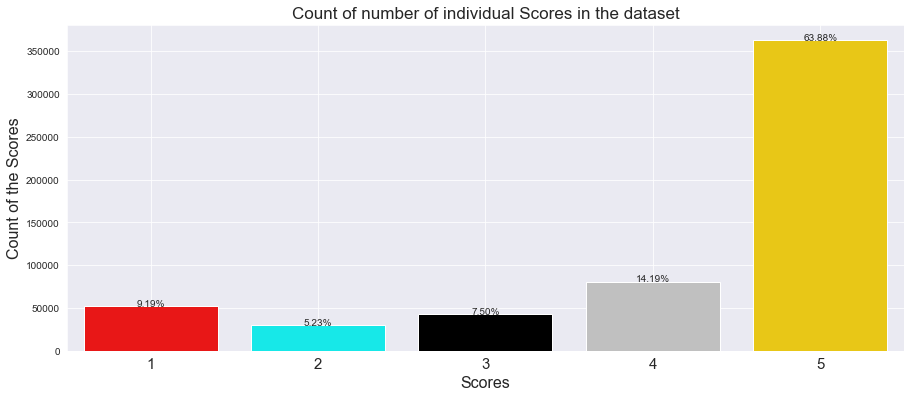

In [12]:
plt.figure(figsize=(15,6))
ax = sns.countplot(data['Score'],
                   saturation=0.82,
                   palette=['red','cyan','black','silver','gold'])
plt.title('Count of number of individual Scores in the dataset',fontsize=17)
plt.ylabel('Count of the Scores',fontsize=16)
plt.xlabel('Scores',fontsize=16)
plt.xticks(fontsize=15)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(data) * 100),
            ha="center") 
plt.grid()
plt.show()

In [13]:
data.loc[data['Score'] == 1,'Score'] = 1
data.loc[data['Score'] == 2,'Score'] = 1
data.loc[data['Score'] == 3,'Score'] = 2
data.loc[data['Score'] == 4,'Score'] = 3
data.loc[data['Score'] == 5,'Score'] = 3

In [14]:
data.Score.value_counts()

3    443764
1     82007
2     42638
Name: Score, dtype: int64

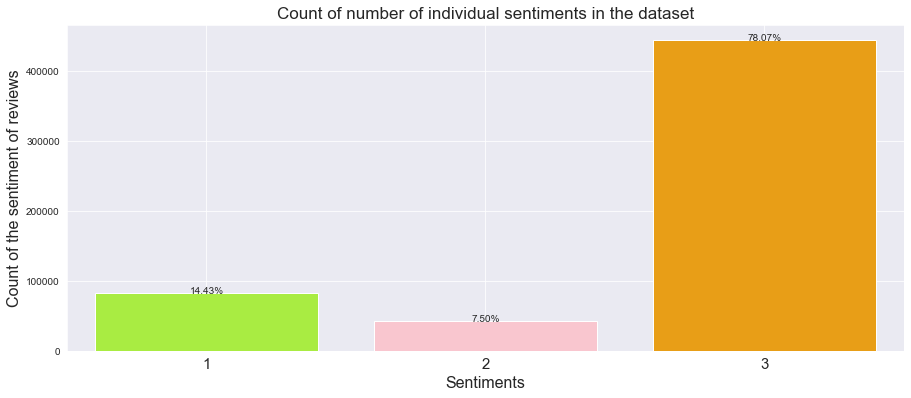

In [15]:
plt.figure(figsize=(15,6))
ax = sns.countplot(data['Score'],
                   saturation=0.82,
                   palette=['greenyellow','pink','orange'])
plt.title('Count of number of individual sentiments in the dataset',fontsize=17)
plt.ylabel('Count of the sentiment of reviews',fontsize=16)
plt.xlabel('Sentiments',fontsize=16)
plt.xticks(fontsize=15)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/len(data) * 100),
            ha="center")
plt.grid()
plt.show()

Preprocessing : 

In [16]:
# printing some random reviews
sent_2773 = data['Text'].values[2773]
print('Review 2773 : \n',sent_2773)
print("="*125)

sent_7530 = data['Text'].values[7530]
print('Review 7530 : \n',sent_7530)
print("="*125)

sent_1500 = data['Text'].values[1500]
print('Review 1500 : \n',sent_1500)
print("="*125)

sent_49065 = data['Text'].values[49065]
print('Review 49065 : \n',sent_49065)
print("="*125)

Review 2773 : 
 MY CATS LOVE THESE MILKY TREATS. THEY ARE A GREAT PRODUCT AND ARE HARD TO FIND IN THE STORES. I FOUND THEM ONCE AT PETSMART AND THEN NEVER FOUND THEM AGAIN UNTIL THIS WEBSITE. THANKS ALOT AND MY CATS ARE SO HAPPY!
Review 7530 : 
 Upon opening the bags, there was a very strong odor of rancid oil. I opened them all, and it was the same. I assumed there would be no refund for opened bags of chips, so I ended up throwing all 12 bags into the garbage.
Review 1500 : 
 These are the freshest dried peppers I have had since I lived in Texas. Difficult to find in PA groceries, but hard and brittle when you do, these arrived in airtight jars with that pliant feel you want in a pepper that has been packed right after drying. I bought 3 jars for a lot of enchilada sauce and beans and rice.
Review 49065 : 
 Two level measuring teaspoons makes at least 30 ounces of tea, good strong tea that is highly stimulating.  I don't even miss coffee now!  Using distilled water makes the best tea

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_2773 = re.sub(r"http\S+", "", sent_2773)
sent_7530 = re.sub(r"http\S+", "", sent_7530)
sent_1500 = re.sub(r"http\S+", "", sent_1500)
sent_49065 = re.sub(r"http\S+", "", sent_49065)

print(sent_2773)
print('*'*125)
print(sent_7530)
print('*'*125)
print(sent_1500)
print('*'*125)
print(sent_49065)

MY CATS LOVE THESE MILKY TREATS. THEY ARE A GREAT PRODUCT AND ARE HARD TO FIND IN THE STORES. I FOUND THEM ONCE AT PETSMART AND THEN NEVER FOUND THEM AGAIN UNTIL THIS WEBSITE. THANKS ALOT AND MY CATS ARE SO HAPPY!
*****************************************************************************************************************************
Upon opening the bags, there was a very strong odor of rancid oil. I opened them all, and it was the same. I assumed there would be no refund for opened bags of chips, so I ended up throwing all 12 bags into the garbage.
*****************************************************************************************************************************
These are the freshest dried peppers I have had since I lived in Texas. Difficult to find in PA groceries, but hard and brittle when you do, these arrived in airtight jars with that pliant feel you want in a pepper that has been packed right after drying. I bought 3 jars for a lot of enchilada sauce and beans an

In [18]:
soup = BeautifulSoup(sent_2773)
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_7530)
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500)
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_49065)
text = soup.get_text()
print(text)

MY CATS LOVE THESE MILKY TREATS. THEY ARE A GREAT PRODUCT AND ARE HARD TO FIND IN THE STORES. I FOUND THEM ONCE AT PETSMART AND THEN NEVER FOUND THEM AGAIN UNTIL THIS WEBSITE. THANKS ALOT AND MY CATS ARE SO HAPPY!
Upon opening the bags, there was a very strong odor of rancid oil. I opened them all, and it was the same. I assumed there would be no refund for opened bags of chips, so I ended up throwing all 12 bags into the garbage.
These are the freshest dried peppers I have had since I lived in Texas. Difficult to find in PA groceries, but hard and brittle when you do, these arrived in airtight jars with that pliant feel you want in a pepper that has been packed right after drying. I bought 3 jars for a lot of enchilada sauce and beans and rice.
Two level measuring teaspoons makes at least 30 ounces of tea, good strong tea that is highly stimulating.  I don't even miss coffee now!  Using distilled water makes the best tea in my opinion.  I drink the first mug straight and the rest I pu

In [19]:
data = data.head(10000)

In [20]:
def remove_shortforms(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    text = re.sub(r"\'m", " am", phrase)
    return text

def remove_html(phrase):
    soup = BeautifulSoup(phrase)
    text = soup.get_text()
    return text

def remove_special_char(text):
    text = re.sub('[^A-Za-z0-9]+'," ",text)
    return text

def remove_wordswithnum(text):
    text = re.sub("\S*\d\S*", "", text).strip()
    return text

def lowercase(text):
    text = text.lower()
    return text

def remove_stop_words(text):
    text = remove_stopwords(text)
    return text

st = SnowballStemmer(language='english')
def stemming(text):
    r= []
    for word in text :
        a = st.stem(word)
        r.append(a)
    return r

def listToString(s):  
    str1 = " "   
    return (str1.join(s))

def remove_punctuations(text):
    text = re.sub(r'[^\w\s]','',text)
    return text

def remove_links(text):
    text = re.sub(r'http\S+', '', text)
    return text

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    text = lemmatizer.lemmatize(text)
    return text

In [21]:
start_time = time.time()

text = data['Text'].apply(lambda x : remove_shortforms(x))
text = text.apply(lambda x : remove_html(x))
text = text.apply(lambda x : remove_special_char(x))
text = text.apply(lambda x : remove_wordswithnum(x))
text = text.apply(lambda x : lowercase(x))
text = text.apply(lambda x : remove_stop_words(x))
text = text.apply(lambda x : listToString(stemming(x.split())))
text = text.apply(lambda x : remove_punctuations(x))
text = text.apply(lambda x : remove_links(x))
text = text.apply(lambda x : lemmatize_words(x))

print('Preprocessing of text done in : ',np.round(time.time() - start_time,3), 'seconds')
text[:4]

Preprocessing of text done in :  22.806 seconds


0    witti littl book make son laugh loud recit car...
1    rememb see air televis year ago child sister l...
2    beetlejuic written movi excel act special effe...
3    twist rumplestiskin captur film star michael k...
Name: Text, dtype: object

In [22]:
data['preprocessed_text'] = text
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,time,preprocessed_text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,3,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,1999-10-08 05:30:00,witti littl book make son laugh loud recit car...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,3,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,1999-10-25 05:30:00,rememb see air televis year ago child sister l...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,3,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,1999-12-02 05:30:00,beetlejuic written movi excel act special effe...
3,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,3,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",1999-12-06 05:30:00,twist rumplestiskin captur film star michael k...
4,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,3,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",1999-12-06 05:30:00,twist rumplestiskin captur film star michael k...


In [23]:
start_time = time.time()

text = data['Summary'].apply(lambda x : remove_shortforms(x))
text = text.apply(lambda x : remove_html(x))
text = text.apply(lambda x : remove_special_char(x))
text = text.apply(lambda x : remove_wordswithnum(x))
text = text.apply(lambda x : lowercase(x))
text = text.apply(lambda x : remove_stop_words(x))
text = text.apply(lambda x : listToString(stemming(x.split())))
text = text.apply(lambda x : remove_punctuations(x))
text = text.apply(lambda x : remove_links(x))
text = text.apply(lambda x : lemmatize_words(x))

print('Preprocessing of summary done in : ',np.round(time.time() - start_time,3), 'seconds')
text[:4]

Preprocessing of summary done in :  3.49 seconds


0                          book educ
1    seri great way spend time child
2                entertainingl funni
3              modern day fairi tale
Name: Summary, dtype: object

In [24]:
data['preprocessed_summary'] = text
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,time,preprocessed_text,preprocessed_summary
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,3,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,1999-10-08 05:30:00,witti littl book make son laugh loud recit car...,book educ
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,3,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,1999-10-25 05:30:00,rememb see air televis year ago child sister l...,seri great way spend time child
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,3,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,1999-12-02 05:30:00,beetlejuic written movi excel act special effe...,entertainingl funni
3,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,3,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",1999-12-06 05:30:00,twist rumplestiskin captur film star michael k...,modern day fairi tale
4,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,3,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",1999-12-06 05:30:00,twist rumplestiskin captur film star michael k...,modern day fairi tale


In [25]:
data = data.reset_index(drop=True)

In [26]:
actual_data = [None] * len(data)
for i in range(len(data)):
    actual_data[i] = data['preprocessed_text'][i] + data['preprocessed_summary'][i] + data['preprocessed_summary'][i]
actual_data[:2]

['witti littl book make son laugh loud recit car drive sing refrain learn whale india droop rose love new word book introduc silli classic book will bet son abl recit memori collegbook educbook educ',
 'rememb see air televis year ago child sister later bought lp day thirti seri book song student teach preschool turn school purchas cd book children tradit liveseri great way spend time childseri great way spend time child']

Bag of words :

In [27]:
start_time = time.time()
bow = CountVectorizer(ngram_range=(1,3), min_df=10)
bow.fit(actual_data)
print('Some feature names in Bag of Words : ',bow.get_feature_names()[:10])
print('='*125)

bow_text = bow.transform(actual_data)
print('Time taken to train BOW model : ',np.round(time.time()-start_time,3),' seconds')
print("The type of count vectorizer ",type(bow_text))
print("The shape of text BOW vectorizer ",bow_text.get_shape())
print("The number of unique words ", bow_text.get_shape()[1])

Some feature names in Bag of Words :  ['abil', 'abl', 'abl buy', 'abl control', 'abl maintain', 'abl order', 'abl purchas', 'abl purchas product', 'abl tasti', 'abl tasti like']
Time taken to train BOW model :  6.666  seconds
The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text BOW vectorizer  (10000, 8971)
The number of unique words  8971


TF-IDF :

In [28]:
start_time = time.time()
tfidf = TfidfVectorizer(ngram_range=(1,3), min_df=10)
tfidf.fit(actual_data)
print("Some sample features in TF-IDF : ",tfidf.get_feature_names()[0:10])
print('='*125)

tfidf_text = tfidf.transform(actual_data)
print('Time taken to train TF-IDF model : ',np.round(time.time()-start_time,3),' seconds')
print("the type of count vectorizer ",type(tfidf_text))
print("the shape of out text TFIDF vectorizer ",tfidf_text.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_text.get_shape()[1])

Some sample features in TF-IDF :  ['abil', 'abl', 'abl buy', 'abl control', 'abl maintain', 'abl order', 'abl purchas', 'abl purchas product', 'abl tasti', 'abl tasti like']
Time taken to train TF-IDF model :  6.913  seconds
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (10000, 8971)
the number of unique words including both unigrams and bigrams  8971


Word2vec : 

In [29]:
# i=0
# list_of_sentance=[] 
# for sentance in tqdm(actual_data):
#     list_of_sentance.append(sentance.split())

# w2v_model = Word2Vec(list_of_sentance,min_count = 5,size = 50, workers = 4)
# print(w2v_model.wv.most_similar('great'))
# print('='*125)
# print(w2v_model.wv.most_similar('worst'))   
# print('='*125)
# print(w2v_model.wv.modet_similar('boy'))   
# print('='*125)
# w2v_words = list(w2v_model.wv.vocab)
# print("number of words that occured minimum 5 times ",len(w2v_words))
# print("sample words ", w2v_words[0:50])

In [30]:
# sent_vectors = []
# for sent in tqdm(list_of_sentance):
#     sent_vec = np.zeros(50) 
#     cnt_words = 0
#     for word in sent: 
#         if word in w2v_words:
#             vec = w2v_model.wv[word]
#             sent_vec += vec
#             cnt_words += 1
#     if cnt_words != 0:
#         sent_vec /= cnt_words
#     sent_vectors.append(sent_vec)
# print(len(sent_vectors))
# print(len(sent_vectors[0]))

TF-IDF weighted word2vec : 

In [31]:
# model = TfidfVectorizer()
# tf_idf_matrix = model.fit_transform(actual_data)
# dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [32]:
# tfidf_feat = model.get_feature_names()
# tfidf_sent_vectors = []
# row=0;
# for sent in tqdm(list_of_sentance):  
#     sent_vec = np.zeros(50) 
#     weight_sum =0; 
#     for word in sent: 
#         if word in w2v_words and word in tfidf_feat:
#             vec = w2v_model.wv[word]
#             tf_idf = dictionary[word]*(sent.count(word)/len(sent))
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
#     if weight_sum != 0:
#         sent_vec /= weight_sum
#     tfidf_sent_vectors.append(sent_vec)
#     row += 1

GLOVE Vectors : 

In [33]:
# print('Loading GloVe vectors...')
# glove = {}
# with open(os.path.join('../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'), encoding = "utf-8") as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         vec = np.asarray(values[1:], dtype='float32')
#         glove[word] = vec
# print(f'Found {len(glove)} word vectors.')

In [34]:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(actual_data)
# sequences = tokenizer.texts_to_sequences(actual_data)
# word2index = tokenizer.word_index
# print("Number of unique tokens : ",len(word2index))

In [35]:
# data_padded = pad_sequences(sequences,1500)
# print(data_padded.shape)
# print(data_padded[0])

In [36]:
# embedding_matrix = np.zeros((len(word2index)+1,200))

# embedding_vec=[]
# for word, i in tqdm(word2index.items()):
#     embedding_vec = word2vec.get(word)
#     if embedding_vec is not None:
#         embedding_matrix[i] = embedding_vec
# print(embedding_matrix.shape)
# print(embedding_matrix[1])

In [37]:
labels = data['Score']
labels.shape

(10000,)

Time based splitting :

In [38]:
bow_text.shape[0]

10000

In [39]:
m = int(bow_text.shape[0]*0.8)
m

8000

In [40]:
train_bow = bow_text[:m]
test_bow = bow_text[m:]
train_labels = labels[:m]
test_labels = labels[m:]
train_tfidf = tfidf_text[:m]
test_tfidf = tfidf_text[m:]

Class distribution :

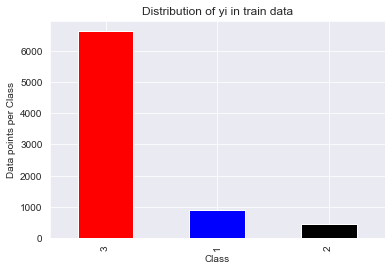

Number of data points in class 3 : 6626 ( 82.825 %)
Number of data points in class 1 : 909 ( 11.362 %)
Number of data points in class 2 : 465 ( 5.812 %)
--------------------------------------------------------------------------------


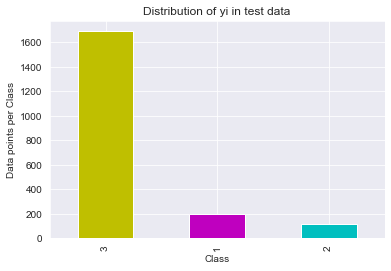

Number of data points in class 3 : 1692 ( 84.6 %)
Number of data points in class 1 : 194 ( 9.7 %)
Number of data points in class 2 : 114 ( 5.7 %)


In [41]:
train_class_distribution = train_labels.value_counts()
test_class_distribution = test_labels.value_counts()
index = test_class_distribution.index.values

my_colors = ['r','b','k']
train_class_distribution.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', index[i], ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_bow.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = ['y','m','c']
test_class_distribution.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', index[i], ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_bow.shape[0]*100), 3), '%)')


In [42]:
def plot_confusion_matrix(test_y,predicted_y):
    C = confusion_matrix(test_y,predicted_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    class_labels = [1,2,3]
    
    print('\n')
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(16,6))
    sns.heatmap(C, annot=True, cmap="viridis", fmt=".3f", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Class',fontsize=15)
    plt.ylabel('Original Class',fontsize=15)
    plt.show()
    
    print('\n')
    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(16,6))
    sns.heatmap(B, annot=True, cmap="RdBu", fmt=".3f", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Class',fontsize=15)
    plt.ylabel('Original Class',fontsize=15)
    plt.show()
    
    print('\n')
    print("-"*50, "Recall matrix", "-"*50)
    plt.figure(figsize=(16,6))
    sns.heatmap(A, annot=True, cmap="BuGn", fmt=".3f", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Class',fontsize=15)
    plt.ylabel('Original Class',fontsize=15)
    plt.show()

Random Model : 

Log loss on Validation Data using Random Model :  1.328723761868923
Log loss on Test Data using Random Model :  1.350145489925467
Accuracy of Random Model :  0.3315
Number of Missclassified points :  1337


-------------------------------------------------- Confusion matrix --------------------------------------------------


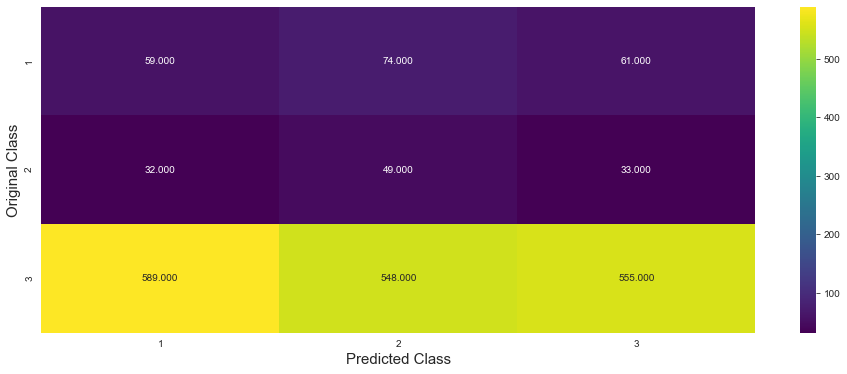



-------------------------------------------------- Precision matrix --------------------------------------------------


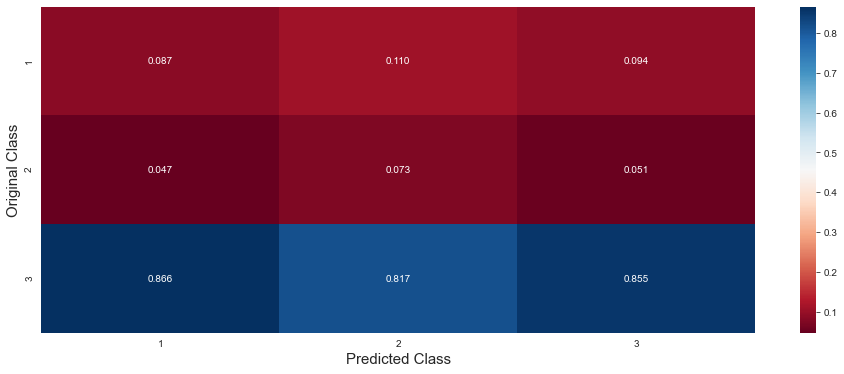



-------------------------------------------------- Recall matrix --------------------------------------------------


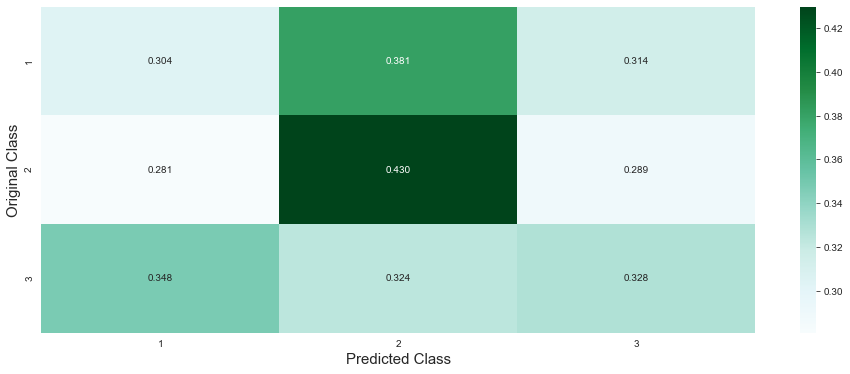

In [101]:
train_temp,val_temp,train_labels_temp,val_labels_temp = train_test_split(train_bow,train_labels,test_size=0.2)

val_predictions = np.zeros((val_temp.shape[0],3))
for i in range(val_temp.shape[0]):
    rand_probs = np.random.rand(1,3)
    val_predictions[i] = (rand_probs/sum(sum(rand_probs)))[0]
print("Log loss on Validation Data using Random Model : ",log_loss(val_labels_temp,val_predictions))

test_predictions = np.zeros((test_bow.shape[0],3))
for i in range(test_bow.shape[0]):
    rand_probs = np.random.rand(1,3)
    test_predictions[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model : ",log_loss(test_labels,test_predictions))

test_labels = test_labels.reset_index(drop=True)
label = [None]*len(test_predictions)
count=0
for k in range(len(test_predictions)):
    value = test_predictions[k].max()
    for i in range(3):
        if test_predictions[k][i] == value:
            label[k] = i+1
            if label[k] != test_labels[k]:
                count = count+1
predictions = label
acc_random = accuracy_score(test_labels,predictions)
print('Accuracy of Random Model : ',acc_random)
miss_random = count
print('Number of Missclassified points : ',count)
loss_random = log_loss(test_labels,test_predictions)
predicted_y =np.argmax(test_predictions, axis=1)
plot_confusion_matrix(test_labels, predicted_y+1)

Logistic Regression (without class balancing) :

Fold started :  0
Log loss for fold 0 for logistic regression with C equal to 0.001 with BOW data is 0.446971097788969
Log loss for fold 0 for logistic regression with C equal to 0.01 with BOW data is 0.426696766018536
Log loss for fold 0 for logistic regression with C equal to 0.1 with BOW data is 0.41796245026277823
Log loss for fold 0 for logistic regression with C equal to 1 with BOW data is 0.4205976673069
Log loss for fold 0 for logistic regression with C equal to 10 with BOW data is 0.4233003989435724
Log loss for fold 0 for logistic regression with C equal to 100 with BOW data is 0.4234189118622866
Log loss for fold 0 for logistic regression with C equal to 1000 with BOW data is 0.42423958148976454
Minimum validation log loss for fold 0 is 0.41796245026277823


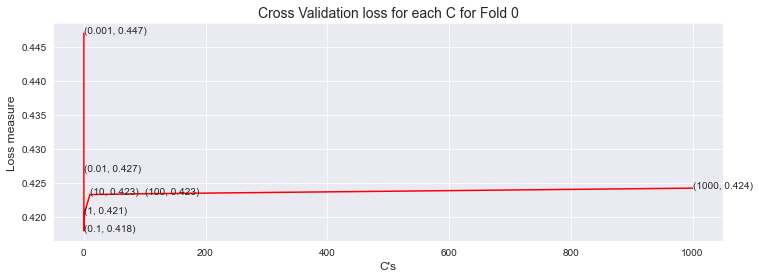

*****************************************************************************************************************************
Fold started :  1
Log loss for fold 1 for logistic regression with C equal to 0.001 with BOW data is 0.5197060913974485
Log loss for fold 1 for logistic regression with C equal to 0.01 with BOW data is 0.49014721091122077
Log loss for fold 1 for logistic regression with C equal to 0.1 with BOW data is 0.47032241245990747
Log loss for fold 1 for logistic regression with C equal to 1 with BOW data is 0.4734757126108983
Log loss for fold 1 for logistic regression with C equal to 10 with BOW data is 0.4815936318993776
Log loss for fold 1 for logistic regression with C equal to 100 with BOW data is 0.4863764015461016
Log loss for fold 1 for logistic regression with C equal to 1000 with BOW data is 0.4892337699280847
Minimum validation log loss for fold 1 is 0.47032241245990747


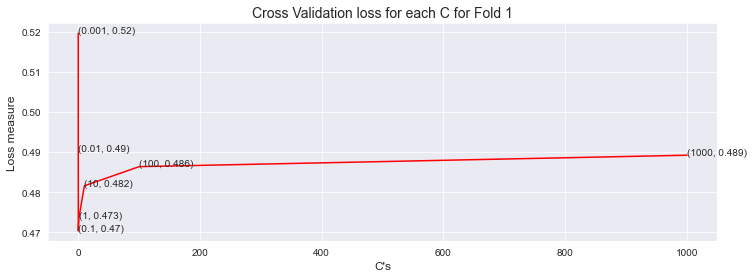

*****************************************************************************************************************************
Fold started :  2
Log loss for fold 2 for logistic regression with C equal to 0.001 with BOW data is 0.5409817966346168
Log loss for fold 2 for logistic regression with C equal to 0.01 with BOW data is 0.5082619111073965
Log loss for fold 2 for logistic regression with C equal to 0.1 with BOW data is 0.5014087382926808
Log loss for fold 2 for logistic regression with C equal to 1 with BOW data is 0.5161727889054227
Log loss for fold 2 for logistic regression with C equal to 10 with BOW data is 0.5271662416648146
Log loss for fold 2 for logistic regression with C equal to 100 with BOW data is 0.5351640008112561
Log loss for fold 2 for logistic regression with C equal to 1000 with BOW data is 0.5396843410386107
Minimum validation log loss for fold 2 is 0.5014087382926808


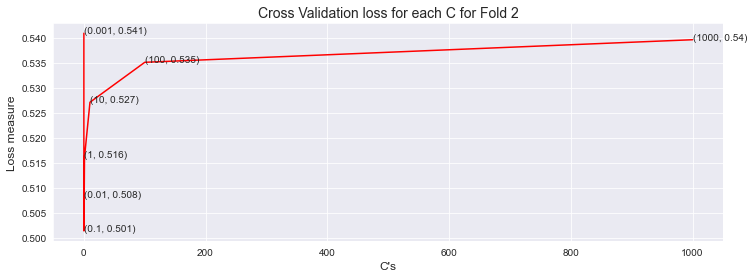

*****************************************************************************************************************************
Fold started :  3
Log loss for fold 3 for logistic regression with C equal to 0.001 with BOW data is 0.5244470962183979
Log loss for fold 3 for logistic regression with C equal to 0.01 with BOW data is 0.4912870374536767
Log loss for fold 3 for logistic regression with C equal to 0.1 with BOW data is 0.47905077597030515
Log loss for fold 3 for logistic regression with C equal to 1 with BOW data is 0.4871580195364259
Log loss for fold 3 for logistic regression with C equal to 10 with BOW data is 0.49470371911692973
Log loss for fold 3 for logistic regression with C equal to 100 with BOW data is 0.499220667640317
Log loss for fold 3 for logistic regression with C equal to 1000 with BOW data is 0.5019457608742645
Minimum validation log loss for fold 3 is 0.47905077597030515


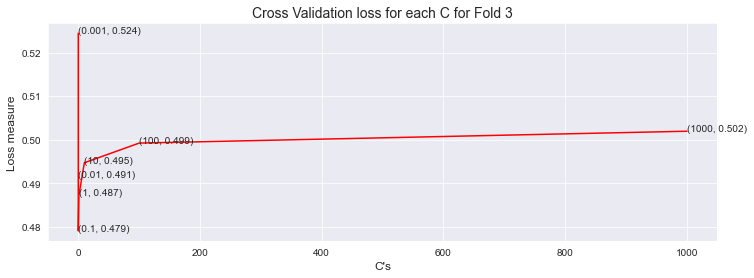

*****************************************************************************************************************************


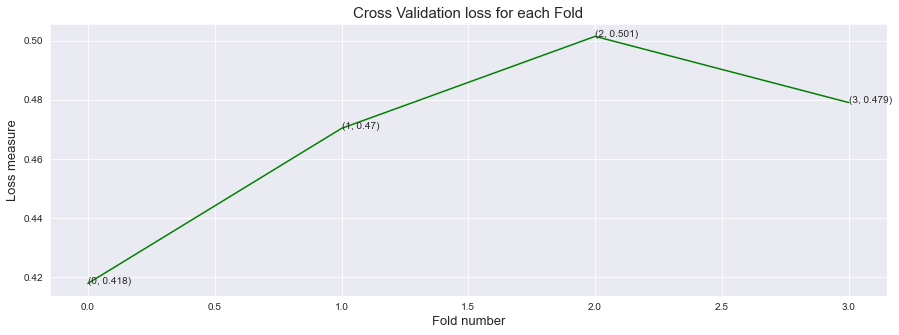

The train log loss is :  0.3736110242968705
The test log loss is :  0.44649511861221913
Accuracy : 0.852
Number of missclassified points :  296
Classification  Report :
               precision    recall  f1-score   support

           1       0.67      0.10      0.18       194
           2       0.00      0.00      0.00       114
           3       0.85      1.00      0.92      1692

    accuracy                           0.85      2000
   macro avg       0.51      0.37      0.37      2000
weighted avg       0.79      0.85      0.80      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


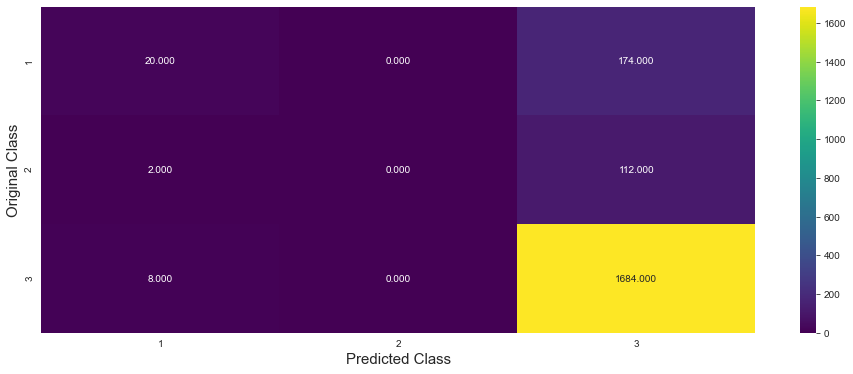



-------------------------------------------------- Precision matrix --------------------------------------------------


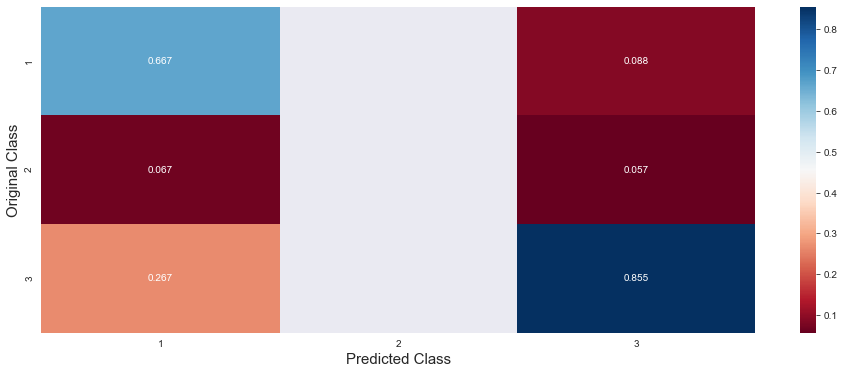



-------------------------------------------------- Recall matrix --------------------------------------------------


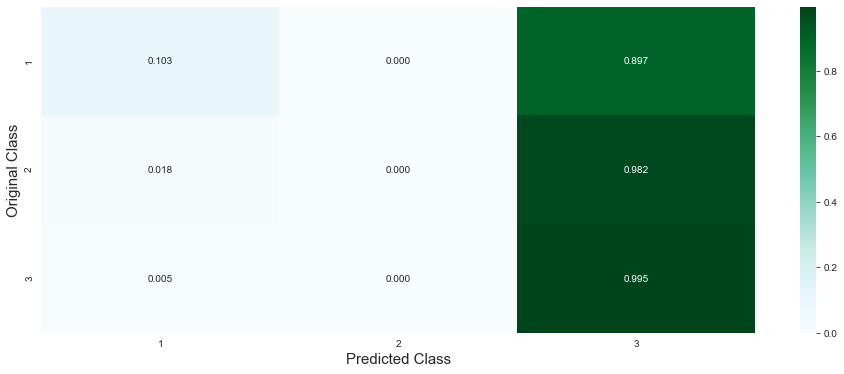

In [44]:
kfold = KFold(n_splits=4)
loss_per_fold = []
best_loss_index = []

for n,(train_idx,val_idx) in enumerate(kfold.split(train_bow,train_labels)):
    
    loss_per_C = []
    
    print('Fold started : ',n)
    train_temp = train_bow[train_idx]
    val_temp = train_bow[val_idx]    
    train_labels_temp = train_labels[train_idx]    
    val_labels_temp = train_labels[val_idx]
    
    C = [0.001,0.01,0.1,1,10,100,1000]
              
    for i in C:
        lr= LogisticRegression(C=i,penalty='l2',max_iter=10000)
        lr.fit(train_temp,train_labels_temp)
        calib_lr = CalibratedClassifierCV(lr)
        calib_lr.fit(train_temp,train_labels_temp)
        val_predictions = calib_lr.predict_proba(val_temp)
        logloss = log_loss(val_labels_temp,val_predictions)
        print(f'Log loss for fold {n} for logistic regression with C equal to {i} with BOW data is {logloss}')
        loss_per_C.append(logloss)
        
    min_loss = min(loss_per_C)
    best_loss_index.append(np.argmin(loss_per_C))
    print(f'Minimum validation log loss for fold {n} is {min_loss}')
    loss_per_fold.append(min_loss)
    
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(C, loss_per_C,c='r')
    for i, txt in enumerate(np.round(loss_per_C,3)):
        ax.annotate((C[i],np.round(txt,3)), (C[i],loss_per_C[i]))
    plt.grid()
    plt.title(f'Cross Validation loss for each C for Fold {n}',fontsize=14)
    plt.xlabel("C's",fontsize=12)
    plt.ylabel("Loss measure",fontsize=12)
    plt.show()
    print('*'*125)
    
N = [0,1,2,3]
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(N, loss_per_fold,c='g')
for i, txt in enumerate(np.round(loss_per_fold,3)):
    ax.annotate((N[i],np.round(txt,3)), (N[i],loss_per_fold[i]))
plt.grid()
plt.title(f'Cross Validation loss for each Fold',fontsize=15)
plt.xlabel("Fold number",fontsize=13)
plt.ylabel("Loss measure",fontsize=13)
plt.show()

predict_train = calib_lr.predict_proba(train_bow)
print("The train log loss is : ",log_loss(train_labels, predict_train, labels=calib_lr.classes_, eps=1e-15))
predict_y = calib_lr.predict_proba(test_bow)
print("The test log loss is : ",log_loss(test_labels, predict_y, labels=calib_lr.classes_, eps=1e-15))

predict = calib_lr.predict(test_bow)
acc_lr_bow = accuracy_score(test_labels,predict)
print('Accuracy :',acc_lr_bow)
miss_lr_bow = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_lr_bow = log_loss(test_labels, predict_y, labels=calib_lr.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

Fold started :  0
Log loss for fold 0 for logistic regression with C equal to 0.001 with TFIDF data is 0.43354382638707933
Log loss for fold 0 for logistic regression with C equal to 0.01 with TFIDF data is 0.4324610751004406
Log loss for fold 0 for logistic regression with C equal to 0.1 with TFIDF data is 0.42574034039333264
Log loss for fold 0 for logistic regression with C equal to 1 with TFIDF data is 0.4138834861940137
Log loss for fold 0 for logistic regression with C equal to 10 with TFIDF data is 0.4121670174217831
Log loss for fold 0 for logistic regression with C equal to 100 with TFIDF data is 0.4113060154126377
Log loss for fold 0 for logistic regression with C equal to 1000 with TFIDF data is 0.40546020798171994
Minimum validation log loss for fold 0 is 0.40546020798171994


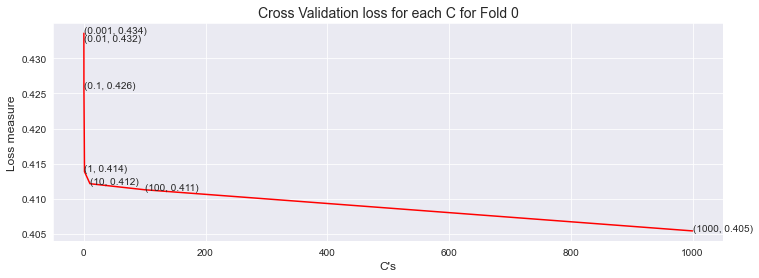

*****************************************************************************************************************************
Fold started :  1
Log loss for fold 1 for logistic regression with C equal to 0.001 with TFIDF data is 0.4873417545602314
Log loss for fold 1 for logistic regression with C equal to 0.01 with TFIDF data is 0.4860121981301504
Log loss for fold 1 for logistic regression with C equal to 0.1 with TFIDF data is 0.4751176396235903
Log loss for fold 1 for logistic regression with C equal to 1 with TFIDF data is 0.44848151755092364
Log loss for fold 1 for logistic regression with C equal to 10 with TFIDF data is 0.4472303068050853
Log loss for fold 1 for logistic regression with C equal to 100 with TFIDF data is 0.4523646819105839
Log loss for fold 1 for logistic regression with C equal to 1000 with TFIDF data is 0.45533196801777764
Minimum validation log loss for fold 1 is 0.4472303068050853


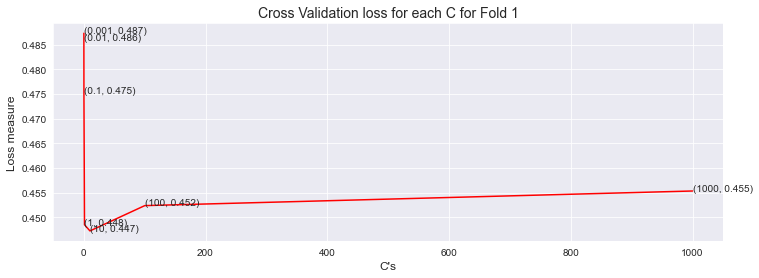

*****************************************************************************************************************************
Fold started :  2
Log loss for fold 2 for logistic regression with C equal to 0.001 with TFIDF data is 0.5108602306594157
Log loss for fold 2 for logistic regression with C equal to 0.01 with TFIDF data is 0.5091459076099675
Log loss for fold 2 for logistic regression with C equal to 0.1 with TFIDF data is 0.49572681473479047
Log loss for fold 2 for logistic regression with C equal to 1 with TFIDF data is 0.4757283418756451
Log loss for fold 2 for logistic regression with C equal to 10 with TFIDF data is 0.48664428927318826
Log loss for fold 2 for logistic regression with C equal to 100 with TFIDF data is 0.49255382778617657
Log loss for fold 2 for logistic regression with C equal to 1000 with TFIDF data is 0.49665067742386976
Minimum validation log loss for fold 2 is 0.4757283418756451


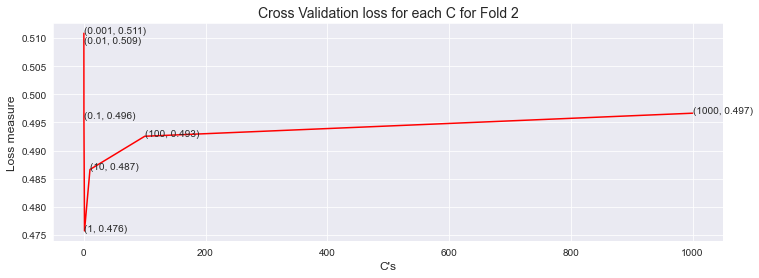

*****************************************************************************************************************************
Fold started :  3
Log loss for fold 3 for logistic regression with C equal to 0.001 with TFIDF data is 0.4946208920930127
Log loss for fold 3 for logistic regression with C equal to 0.01 with TFIDF data is 0.4920985125181062
Log loss for fold 3 for logistic regression with C equal to 0.1 with TFIDF data is 0.4756484454132304
Log loss for fold 3 for logistic regression with C equal to 1 with TFIDF data is 0.45087349261625365
Log loss for fold 3 for logistic regression with C equal to 10 with TFIDF data is 0.4544683867649718
Log loss for fold 3 for logistic regression with C equal to 100 with TFIDF data is 0.4600582567653713
Log loss for fold 3 for logistic regression with C equal to 1000 with TFIDF data is 0.46717673058542697
Minimum validation log loss for fold 3 is 0.45087349261625365


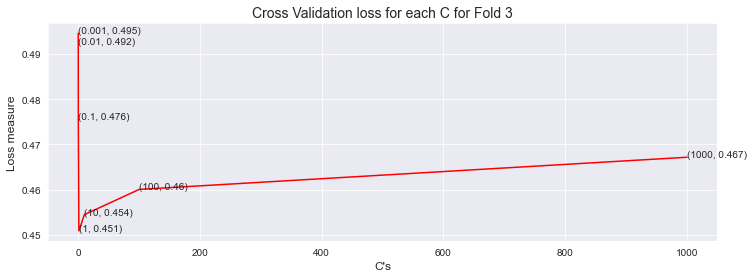

*****************************************************************************************************************************


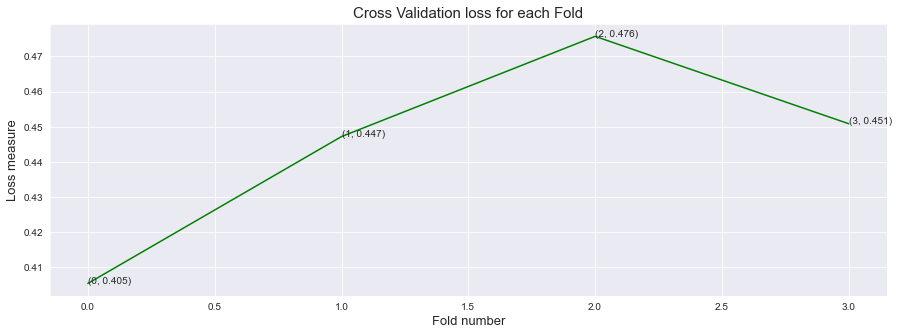

The train log loss is :  0.26901361825802184
The test log loss is :  0.4159816387556774
Accuracy : 0.869
Number of missclassified points :  262
Classification  Report :
               precision    recall  f1-score   support

           1       0.68      0.27      0.38       194
           2       1.00      0.02      0.03       114
           3       0.88      1.00      0.93      1692

    accuracy                           0.87      2000
   macro avg       0.85      0.43      0.45      2000
weighted avg       0.86      0.87      0.83      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


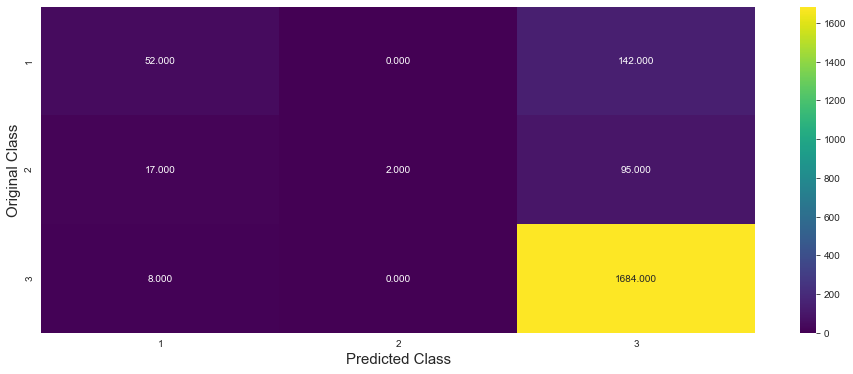



-------------------------------------------------- Precision matrix --------------------------------------------------


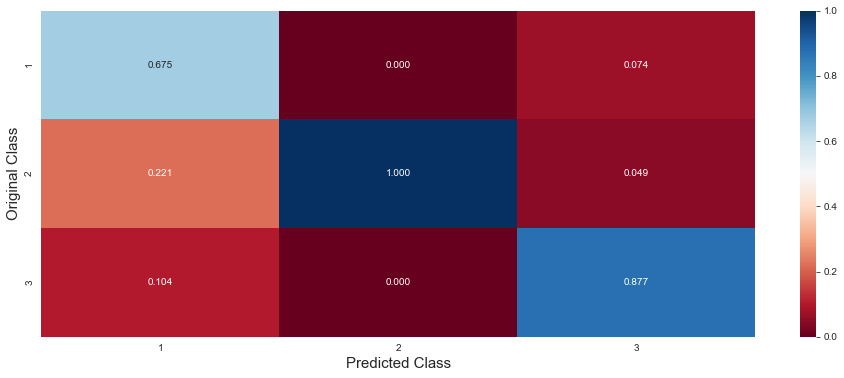



-------------------------------------------------- Recall matrix --------------------------------------------------


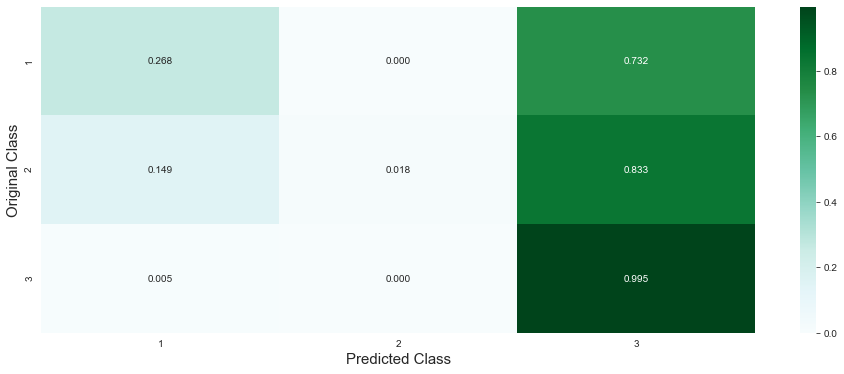

In [45]:
kfold = KFold(n_splits=4)
loss_per_fold = []
best_loss_index = []

for n,(train_idx,val_idx) in enumerate(kfold.split(train_tfidf,train_labels)):
    
    loss_per_C = []
    
    print('Fold started : ',n)
    train_temp = train_tfidf[train_idx]
    val_temp = train_tfidf[val_idx]    
    train_labels_temp = train_labels[train_idx]    
    val_labels_temp = train_labels[val_idx]
    
    C = [0.001,0.01,0.1,1,10,100,1000]
              
    for i in C:
        lr= LogisticRegression(C=i,penalty='l2',max_iter=10000)
        lr.fit(train_temp,train_labels_temp)
        calib_lr = CalibratedClassifierCV(lr)
        calib_lr.fit(train_temp,train_labels_temp)
        val_predictions = calib_lr.predict_proba(val_temp)
        logloss = log_loss(val_labels_temp,val_predictions)
        print(f'Log loss for fold {n} for logistic regression with C equal to {i} with TFIDF data is {logloss}')
        loss_per_C.append(logloss)
        
    min_loss = min(loss_per_C)
    best_loss_index.append(np.argmin(loss_per_C))
    print(f'Minimum validation log loss for fold {n} is {min_loss}')
    loss_per_fold.append(min_loss)
    
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(C, loss_per_C,c='r')
    for i, txt in enumerate(np.round(loss_per_C,3)):
        ax.annotate((C[i],np.round(txt,3)), (C[i],loss_per_C[i]))
    plt.grid()
    plt.title(f'Cross Validation loss for each C for Fold {n}',fontsize=14)
    plt.xlabel("C's",fontsize=12)
    plt.ylabel("Loss measure",fontsize=12)
    plt.show()
    print('*'*125)
    
N = [0,1,2,3]
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(N, loss_per_fold,c='g')
for i, txt in enumerate(np.round(loss_per_fold,3)):
    ax.annotate((N[i],np.round(txt,3)), (N[i],loss_per_fold[i]))
plt.grid()
plt.title(f'Cross Validation loss for each Fold',fontsize=15)
plt.xlabel("Fold number",fontsize=13)
plt.ylabel("Loss measure",fontsize=13)
plt.show()

predict_train = calib_lr.predict_proba(train_tfidf)
print("The train log loss is : ",log_loss(train_labels, predict_train, labels=calib_lr.classes_, eps=1e-15))
predict_y = calib_lr.predict_proba(test_tfidf)
print("The test log loss is : ",log_loss(test_labels, predict_y, labels=calib_lr.classes_, eps=1e-15))

predict = calib_lr.predict(test_tfidf)
acc_lr_tfidf = accuracy_score(test_labels,predict)
print('Accuracy :',acc_lr_tfidf)
miss_lr_tfidf = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_lr_tfidf = log_loss(test_labels, predict_y, labels=calib_lr.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

Logistic Regression (with class balancing) :

Fold started :  0
Log loss for fold 0 for logistic regression with C equal to 0.01 with BOW data is 0.4305469464605339
Log loss for fold 0 for logistic regression with C equal to 0.1 with BOW data is 0.423659306494004
Log loss for fold 0 for logistic regression with C equal to 1 with BOW data is 0.42416781146714516
Log loss for fold 0 for logistic regression with C equal to 10 with BOW data is 0.4248010494156008
Log loss for fold 0 for logistic regression with C equal to 50 with BOW data is 0.4240362755434349
Minimum validation log loss for fold 0 is 0.423659306494004


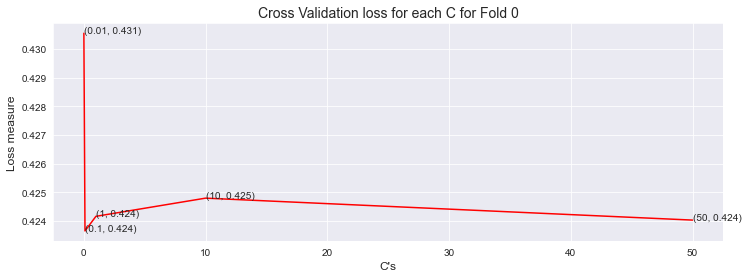

*****************************************************************************************************************************
Fold started :  1
Log loss for fold 1 for logistic regression with C equal to 0.01 with BOW data is 0.4913675631214861
Log loss for fold 1 for logistic regression with C equal to 0.1 with BOW data is 0.47886838473517895
Log loss for fold 1 for logistic regression with C equal to 1 with BOW data is 0.480864024749783
Log loss for fold 1 for logistic regression with C equal to 10 with BOW data is 0.4856910066143072
Log loss for fold 1 for logistic regression with C equal to 50 with BOW data is 0.48816961036928885
Minimum validation log loss for fold 1 is 0.47886838473517895


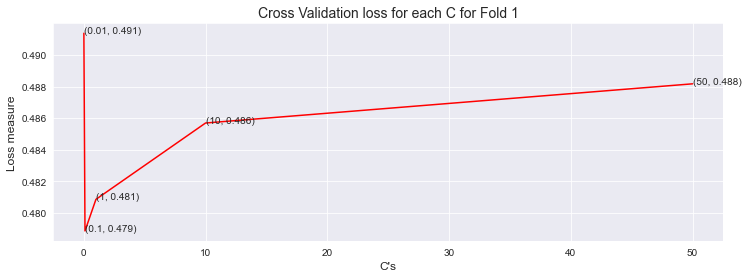

*****************************************************************************************************************************
Fold started :  2
Log loss for fold 2 for logistic regression with C equal to 0.01 with BOW data is 0.5153517198659523
Log loss for fold 2 for logistic regression with C equal to 0.1 with BOW data is 0.5149243671637335
Log loss for fold 2 for logistic regression with C equal to 1 with BOW data is 0.5238860891249298
Log loss for fold 2 for logistic regression with C equal to 10 with BOW data is 0.5313052531927842
Log loss for fold 2 for logistic regression with C equal to 50 with BOW data is 0.5366767303145306
Minimum validation log loss for fold 2 is 0.5149243671637335


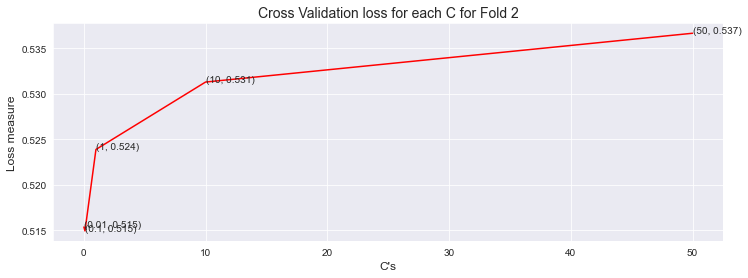

*****************************************************************************************************************************
Fold started :  3
Log loss for fold 3 for logistic regression with C equal to 0.01 with BOW data is 0.5007570189862955
Log loss for fold 3 for logistic regression with C equal to 0.1 with BOW data is 0.49267706125775335
Log loss for fold 3 for logistic regression with C equal to 1 with BOW data is 0.49562613748474516
Log loss for fold 3 for logistic regression with C equal to 10 with BOW data is 0.49927536933761474
Log loss for fold 3 for logistic regression with C equal to 50 with BOW data is 0.5018069492815498
Minimum validation log loss for fold 3 is 0.49267706125775335


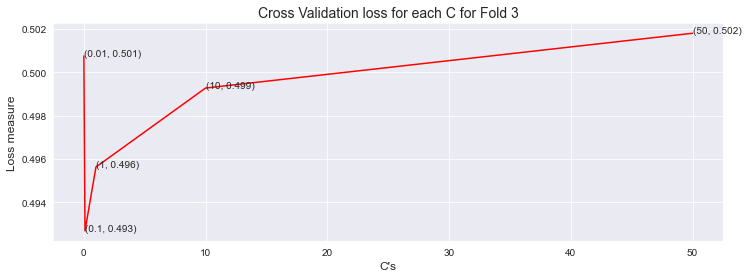

*****************************************************************************************************************************


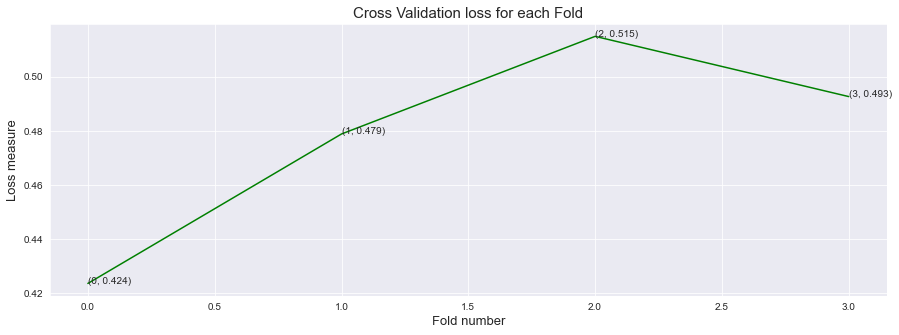

The train log loss is :  0.3700268492078303
The test log loss is :  0.44684987239015017
Accuracy : 0.852
Number of missclassified points :  296
Classification  Report :
               precision    recall  f1-score   support

           1       0.67      0.10      0.18       194
           2       0.00      0.00      0.00       114
           3       0.85      1.00      0.92      1692

    accuracy                           0.85      2000
   macro avg       0.51      0.37      0.37      2000
weighted avg       0.79      0.85      0.80      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


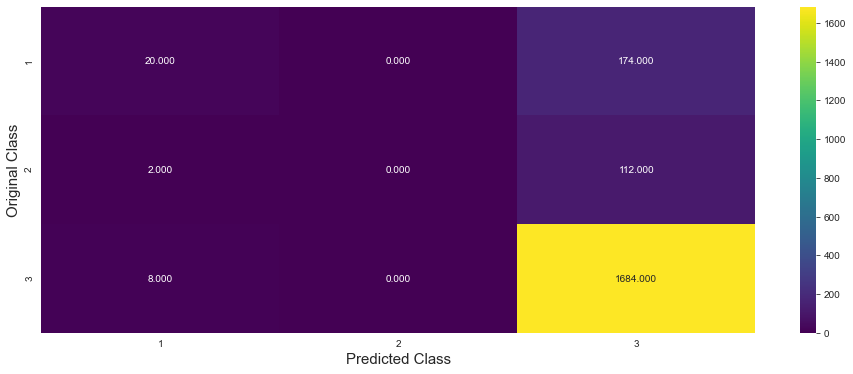



-------------------------------------------------- Precision matrix --------------------------------------------------


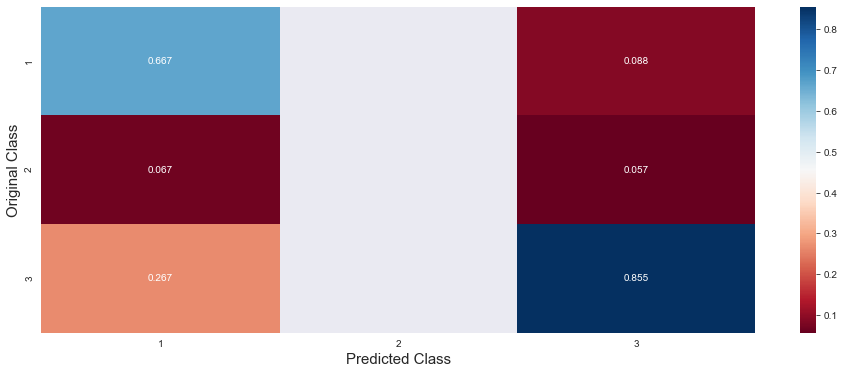



-------------------------------------------------- Recall matrix --------------------------------------------------


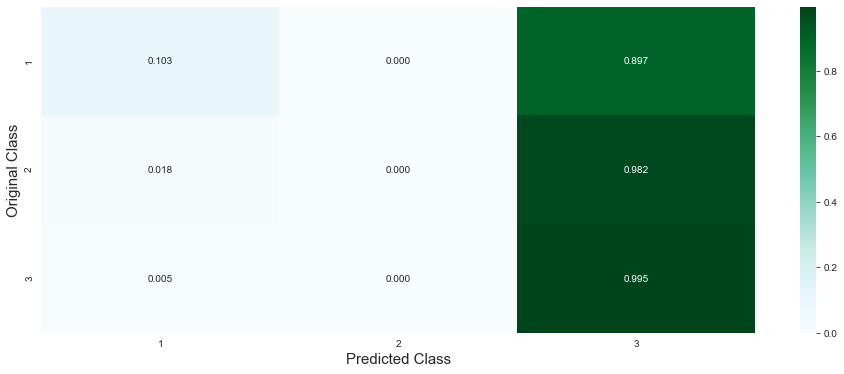

In [46]:
kfold = KFold(n_splits=4)
loss_per_fold = []
best_loss_index = []

for n,(train_idx,val_idx) in enumerate(kfold.split(train_bow,train_labels)):
    
    loss_per_C = []
    
    print('Fold started : ',n)
    train_temp = train_bow[train_idx]
    val_temp = train_bow[val_idx]    
    train_labels_temp = train_labels[train_idx]    
    val_labels_temp = train_labels[val_idx]
    
    C = [0.01,0.1,1,10,50]
              
    for i in C:
        lr= LogisticRegression(C=i,class_weight='balanced',penalty='l2',max_iter=10000)
        lr.fit(train_temp,train_labels_temp)
        calib_lr = CalibratedClassifierCV(lr)
        calib_lr.fit(train_temp,train_labels_temp)
        val_predictions = calib_lr.predict_proba(val_temp)
        logloss = log_loss(val_labels_temp,val_predictions)
        print(f'Log loss for fold {n} for logistic regression with C equal to {i} with BOW data is {logloss}')
        loss_per_C.append(logloss)
        
    min_loss = min(loss_per_C)
    best_loss_index.append(np.argmin(loss_per_C))
    print(f'Minimum validation log loss for fold {n} is {min_loss}')
    loss_per_fold.append(min_loss)
    
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(C, loss_per_C,c='r')
    for i, txt in enumerate(np.round(loss_per_C,3)):
        ax.annotate((C[i],np.round(txt,3)), (C[i],loss_per_C[i]))
    plt.grid()
    plt.title(f'Cross Validation loss for each C for Fold {n}',fontsize=14)
    plt.xlabel("C's",fontsize=12)
    plt.ylabel("Loss measure",fontsize=12)
    plt.show()
    print('*'*125)
    
N = [0,1,2,3]
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(N, loss_per_fold,c='g')
for i, txt in enumerate(np.round(loss_per_fold,3)):
    ax.annotate((N[i],np.round(txt,3)), (N[i],loss_per_fold[i]))
plt.grid()
plt.title(f'Cross Validation loss for each Fold',fontsize=15)
plt.xlabel("Fold number",fontsize=13)
plt.ylabel("Loss measure",fontsize=13)
plt.show()

predict_train = calib_lr.predict_proba(train_bow)
print("The train log loss is : ",log_loss(train_labels, predict_train, labels=calib_lr.classes_, eps=1e-15))
predict_y = calib_lr.predict_proba(test_bow)
print("The test log loss is : ",log_loss(test_labels, predict_y, labels=calib_lr.classes_, eps=1e-15))

predict = calib_lr.predict(test_bow)
acc_lr_bow_balanced = accuracy_score(test_labels,predict)
print('Accuracy :',acc_lr_bow_balanced)
miss_lr_bow_balanced = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_lr_bow_balanced = log_loss(test_labels, predict_y, labels=calib_lr.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

Fold started :  0
Log loss for fold 0 for logistic regression with C equal to 0.01 with TFIDF data is 0.44226390090979395
Log loss for fold 0 for logistic regression with C equal to 0.1 with TFIDF data is 0.43347217995903276
Log loss for fold 0 for logistic regression with C equal to 1 with TFIDF data is 0.4217408084431395
Log loss for fold 0 for logistic regression with C equal to 10 with TFIDF data is 0.41613751912645736
Log loss for fold 0 for logistic regression with C equal to 50 with TFIDF data is 0.41264631645362
Minimum validation log loss for fold 0 is 0.41264631645362


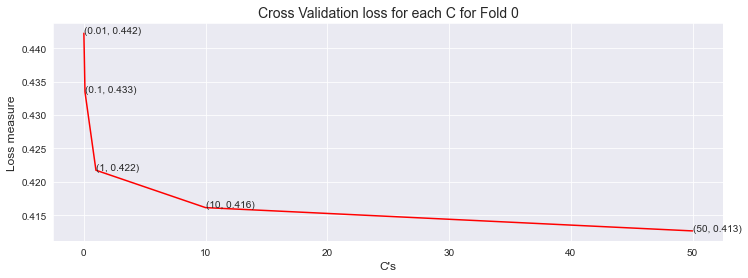

*****************************************************************************************************************************
Fold started :  1
Log loss for fold 1 for logistic regression with C equal to 0.01 with TFIDF data is 0.5002126148779066
Log loss for fold 1 for logistic regression with C equal to 0.1 with TFIDF data is 0.47860643016580756
Log loss for fold 1 for logistic regression with C equal to 1 with TFIDF data is 0.4575716672531406
Log loss for fold 1 for logistic regression with C equal to 10 with TFIDF data is 0.454083386999777
Log loss for fold 1 for logistic regression with C equal to 50 with TFIDF data is 0.45582105997645334
Minimum validation log loss for fold 1 is 0.454083386999777


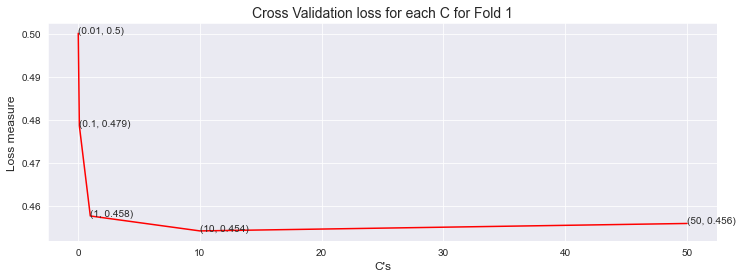

*****************************************************************************************************************************
Fold started :  2
Log loss for fold 2 for logistic regression with C equal to 0.01 with TFIDF data is 0.5223758153893107
Log loss for fold 2 for logistic regression with C equal to 0.1 with TFIDF data is 0.5050856945693419
Log loss for fold 2 for logistic regression with C equal to 1 with TFIDF data is 0.49239221243465975
Log loss for fold 2 for logistic regression with C equal to 10 with TFIDF data is 0.4945223426622889
Log loss for fold 2 for logistic regression with C equal to 50 with TFIDF data is 0.4966730466170594
Minimum validation log loss for fold 2 is 0.49239221243465975


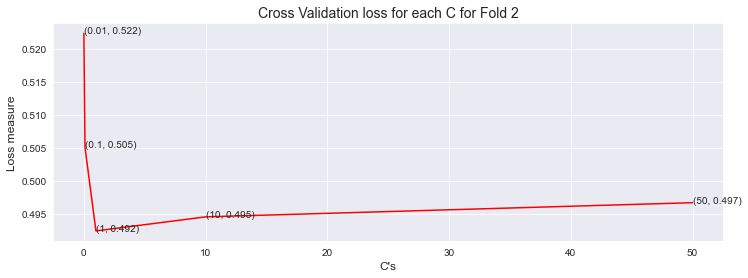

*****************************************************************************************************************************
Fold started :  3
Log loss for fold 3 for logistic regression with C equal to 0.01 with TFIDF data is 0.5076454616594888
Log loss for fold 3 for logistic regression with C equal to 0.1 with TFIDF data is 0.4860276919350762
Log loss for fold 3 for logistic regression with C equal to 1 with TFIDF data is 0.46647238544396474
Log loss for fold 3 for logistic regression with C equal to 10 with TFIDF data is 0.46326616075247407
Log loss for fold 3 for logistic regression with C equal to 50 with TFIDF data is 0.46535586817691116
Minimum validation log loss for fold 3 is 0.46326616075247407


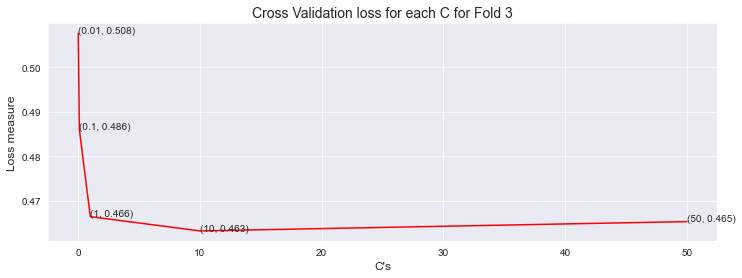

*****************************************************************************************************************************


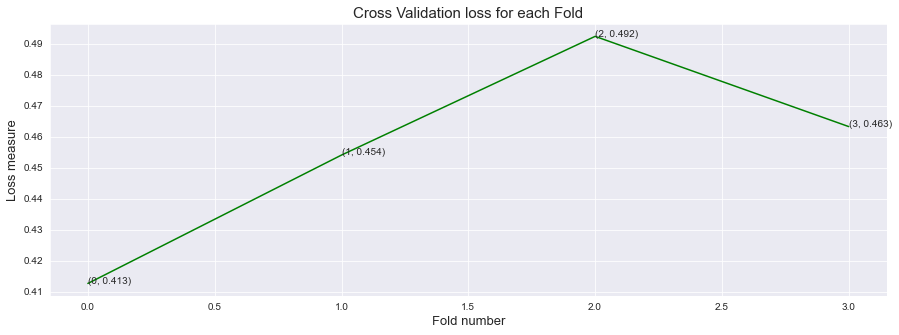

The train log loss is :  0.26864296157925327
The test log loss is :  0.4167059703092559
Accuracy : 0.8685
Number of missclassified points :  263
Classification  Report :
               precision    recall  f1-score   support

           1       0.68      0.27      0.39       194
           2       1.00      0.01      0.02       114
           3       0.88      1.00      0.93      1692

    accuracy                           0.87      2000
   macro avg       0.85      0.42      0.44      2000
weighted avg       0.86      0.87      0.83      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


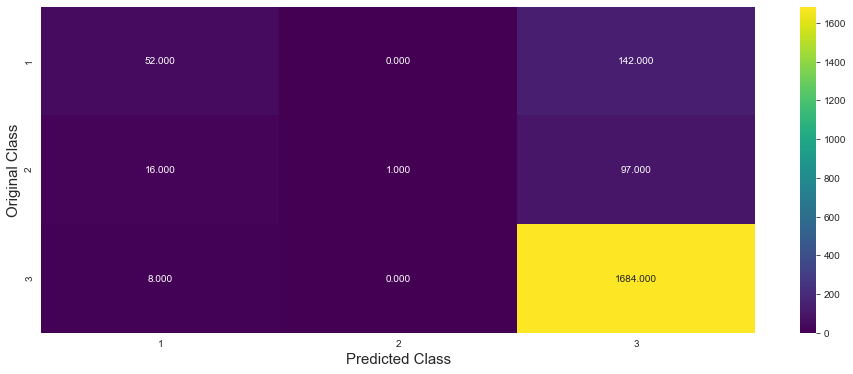



-------------------------------------------------- Precision matrix --------------------------------------------------


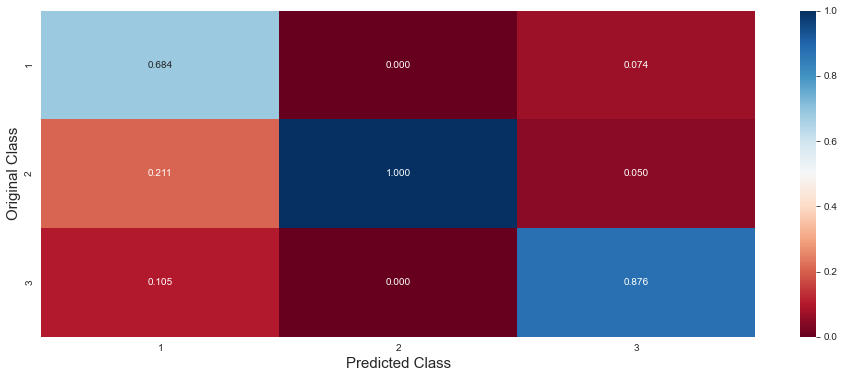



-------------------------------------------------- Recall matrix --------------------------------------------------


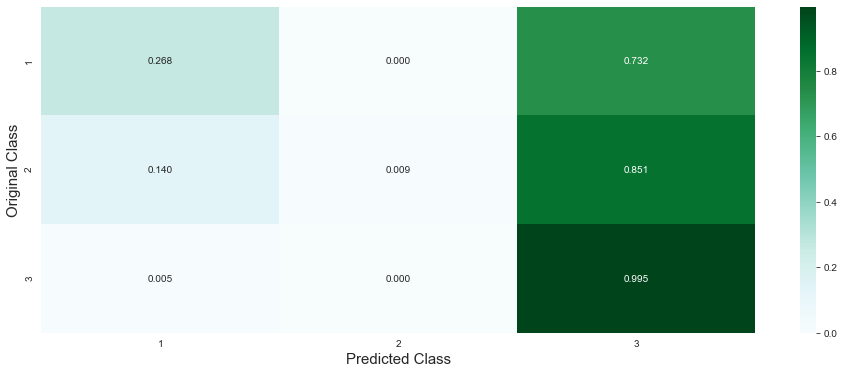

In [47]:
kfold = KFold(n_splits=4)
loss_per_fold = []
best_loss_index = []

for n,(train_idx,val_idx) in enumerate(kfold.split(train_tfidf,train_labels)):
    
    loss_per_C = []
    
    print('Fold started : ',n)
    train_temp = train_tfidf[train_idx]
    val_temp = train_tfidf[val_idx]    
    train_labels_temp = train_labels[train_idx]    
    val_labels_temp = train_labels[val_idx]
    
    C = [0.01,0.1,1,10,50]
              
    for i in C:
        lr= LogisticRegression(C=i,class_weight='balanced',penalty='l2',max_iter=10000)
        lr.fit(train_temp,train_labels_temp)
        calib_lr = CalibratedClassifierCV(lr)
        calib_lr.fit(train_temp,train_labels_temp)
        val_predictions = calib_lr.predict_proba(val_temp)
        logloss = log_loss(val_labels_temp,val_predictions)
        print(f'Log loss for fold {n} for logistic regression with C equal to {i} with TFIDF data is {logloss}')
        loss_per_C.append(logloss)
        
    min_loss = min(loss_per_C)
    best_loss_index.append(np.argmin(loss_per_C))
    print(f'Minimum validation log loss for fold {n} is {min_loss}')
    loss_per_fold.append(min_loss)
    
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(C, loss_per_C,c='r')
    for i, txt in enumerate(np.round(loss_per_C,3)):
        ax.annotate((C[i],np.round(txt,3)), (C[i],loss_per_C[i]))
    plt.grid()
    plt.title(f'Cross Validation loss for each C for Fold {n}',fontsize=14)
    plt.xlabel("C's",fontsize=12)
    plt.ylabel("Loss measure",fontsize=12)
    plt.show()
    print('*'*125)
    
N = [0,1,2,3]
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(N, loss_per_fold,c='g')
for i, txt in enumerate(np.round(loss_per_fold,3)):
    ax.annotate((N[i],np.round(txt,3)), (N[i],loss_per_fold[i]))
plt.grid()
plt.title(f'Cross Validation loss for each Fold',fontsize=15)
plt.xlabel("Fold number",fontsize=13)
plt.ylabel("Loss measure",fontsize=13)
plt.show()

predict_train = calib_lr.predict_proba(train_tfidf)
print("The train log loss is : ",log_loss(train_labels, predict_train, labels=calib_lr.classes_, eps=1e-15))
predict_y = calib_lr.predict_proba(test_tfidf)
print("The test log loss is : ",log_loss(test_labels, predict_y, labels=calib_lr.classes_, eps=1e-15))

predict = calib_lr.predict(test_tfidf)
acc_lr_tfidf_balanced = accuracy_score(test_labels,predict)
print('Accuracy :',acc_lr_tfidf_balanced)
miss_lr_tfidf_balanced = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_lr_tfidf_balanced = log_loss(test_labels, predict_y, labels=calib_lr.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

Simple CV strategy : 

In [48]:
m = int(bow_text.shape[0]*0.8)
v = int(m*0.8)
m,v

(8000, 6400)

In [49]:
train_bow = bow_text[:m]
test_bow = bow_text[m:]
train_labels = labels[:m]
test_labels = labels[m:]
train_tfidf = tfidf_text[:m]
test_tfidf = tfidf_text[m:]

cv_bow = train_bow[v:]
train_bow = train_bow[:v]
cv_tfidf = train_tfidf[v:]
train_tfidf = train_tfidf[:v]
cv_labels = train_labels[v:]
train_labels = train_labels[:v]

In [50]:
train_labels.shape,cv_labels.shape,test_labels.shape

((6400,), (1600,), (2000,))

In [51]:
train_bow.shape,cv_bow.shape,test_bow.shape

((6400, 8971), (1600, 8971), (2000, 8971))

In [52]:
train_tfidf.shape,cv_tfidf.shape,test_tfidf.shape

((6400, 8971), (1600, 8971), (2000, 8971))

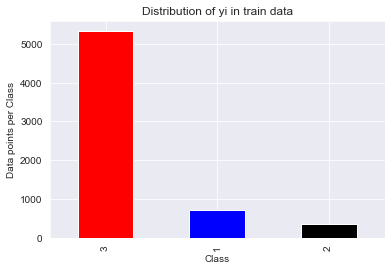

Number of data points in class 3 : 5321 ( 83.141 %)
Number of data points in class 1 : 720 ( 11.25 %)
Number of data points in class 2 : 359 ( 5.609 %)
--------------------------------------------------------------------------------


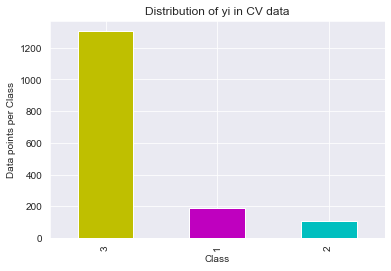

Number of data points in class 3 : 1305 ( 81.562 %)
Number of data points in class 1 : 189 ( 11.812 %)
Number of data points in class 2 : 106 ( 6.625 %)
--------------------------------------------------------------------------------


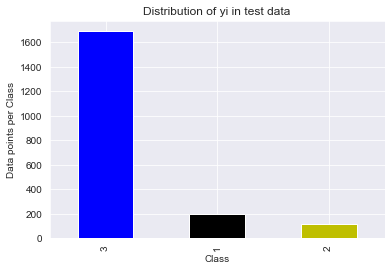

Number of data points in class 3 : 1692 ( 84.6 %)
Number of data points in class 1 : 194 ( 9.7 %)
Number of data points in class 2 : 114 ( 5.7 %)


In [53]:
train_class_distribution = train_labels.value_counts()
cv_class_distribution = cv_labels.value_counts()
test_class_distribution = test_labels.value_counts()
index = train_class_distribution.index.values

my_colors = ['r','b','k']
train_class_distribution.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', index[i], ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_bow.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = ['y','m','c']
cv_class_distribution.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in CV data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', index[i], ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_bow.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = ['b','k','y']
test_class_distribution.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', index[i], ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_bow.shape[0]*100), 3), '%)')


RBF SVM : 

The train log loss is :  0.44300273542126606
The validation log loss is :  0.5702467668967093
The test log loss is :  0.48310334213780043
Accuracy : 0.1915
Number of missclassified points :  1617
Classification  Report :
               precision    recall  f1-score   support

           1       0.11      0.98      0.19       194
           2       0.00      0.00      0.00       114
           3       0.90      0.11      0.20      1692

    accuracy                           0.19      2000
   macro avg       0.34      0.36      0.13      2000
weighted avg       0.77      0.19      0.19      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


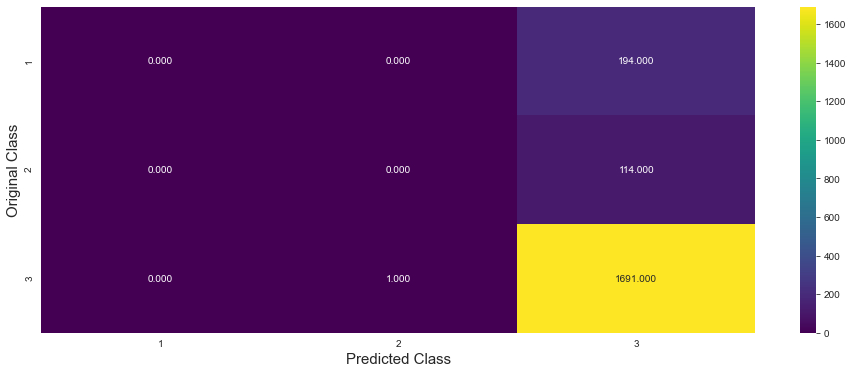



-------------------------------------------------- Precision matrix --------------------------------------------------


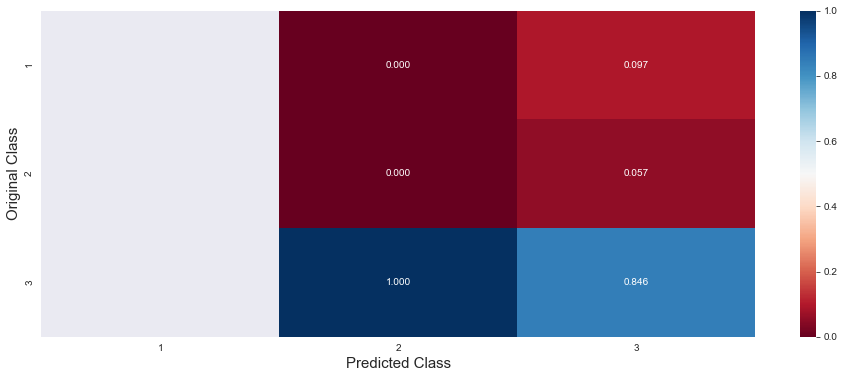



-------------------------------------------------- Recall matrix --------------------------------------------------


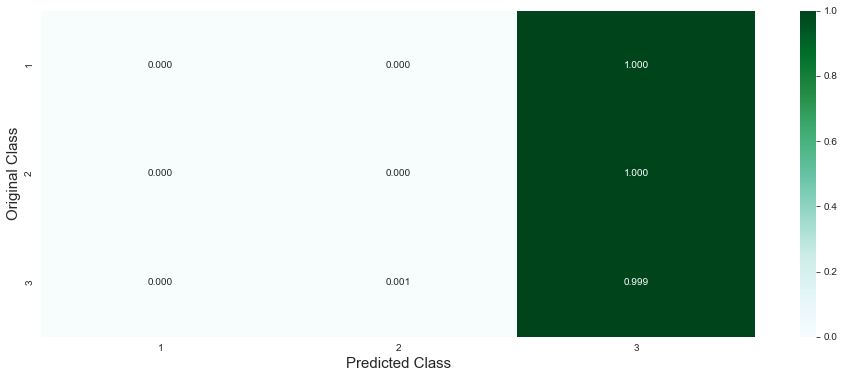

In [54]:
# params = {
#     'C':[0.01,0.1,1]
# #     'gamma':['scale','auto'],    
#          }

# svm = SVC(kernel='rbf',probability=True,class_weight='balanced')
# svm.fit(train_bow,train_labels)
# clf = GridSearchCV(svm,param_grid=params,scoring='f1_micro',cv=5,verbose=2,n_jobs=-1)
# clf.fit(train_bow,train_labels)

# print('Best Parameters : \n',clf.best_params_)
# print('Best score : \n',clf.best_score_)
# print('Best Estimator : \n',clf.best_estimator_)

# best_params = clf.best_params_
svm = SVC(kernel='rbf',probability=True,C=1,gamma='auto',class_weight='balanced')
svm.fit(train_bow,train_labels)

predict_train = svm.predict_proba(train_bow)
print("The train log loss is : ",log_loss(train_labels, predict_train, labels=svm.classes_, eps=1e-15))
predict_cv = svm.predict_proba(cv_bow)
print("The validation log loss is : ",log_loss(cv_labels, predict_cv, labels=svm.classes_, eps=1e-15))
predict_y = svm.predict_proba(test_bow)
print("The test log loss is : ",log_loss(test_labels, predict_y, labels=svm.classes_, eps=1e-15))

predict = svm.predict(test_bow)
acc_rbf_svm_bow = accuracy_score(test_labels,predict)
print('Accuracy :',acc_rbf_svm_bow)
miss_rbf_svm_bow = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_rbf_svm_bow = log_loss(test_labels, predict_y, labels=svm.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

The train log loss is :  0.561147481832816
The validation log loss is :  0.5987157538699016
The test log loss is :  0.5332295931804387
Accuracy : 0.846
Number of missclassified points :  308
Classification  Report :
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       194
           2       0.00      0.00      0.00       114
           3       0.85      1.00      0.92      1692

    accuracy                           0.85      2000
   macro avg       0.28      0.33      0.31      2000
weighted avg       0.72      0.85      0.78      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


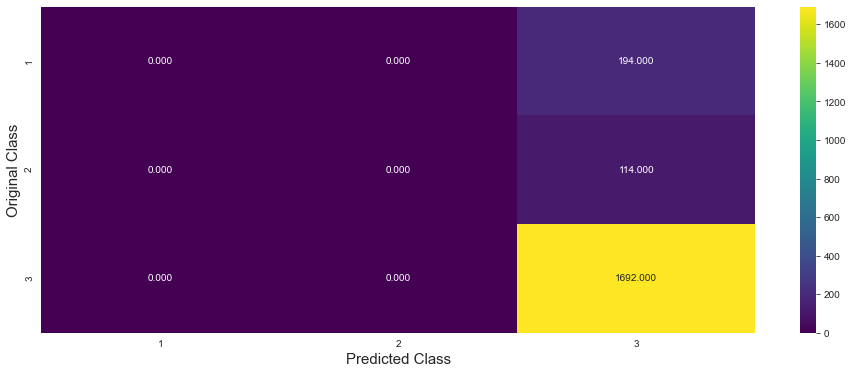



-------------------------------------------------- Precision matrix --------------------------------------------------


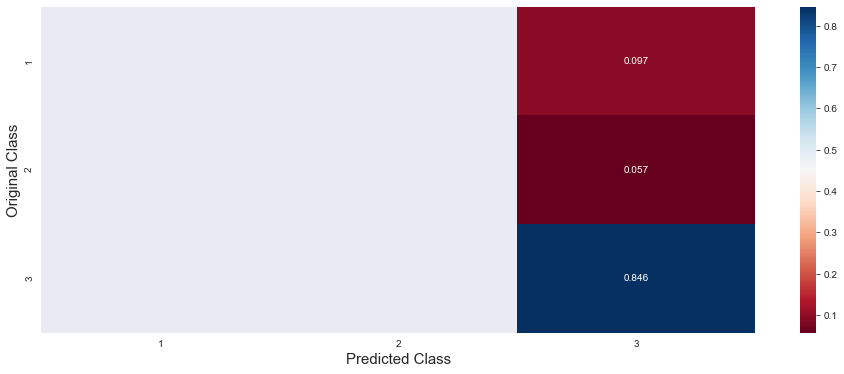



-------------------------------------------------- Recall matrix --------------------------------------------------


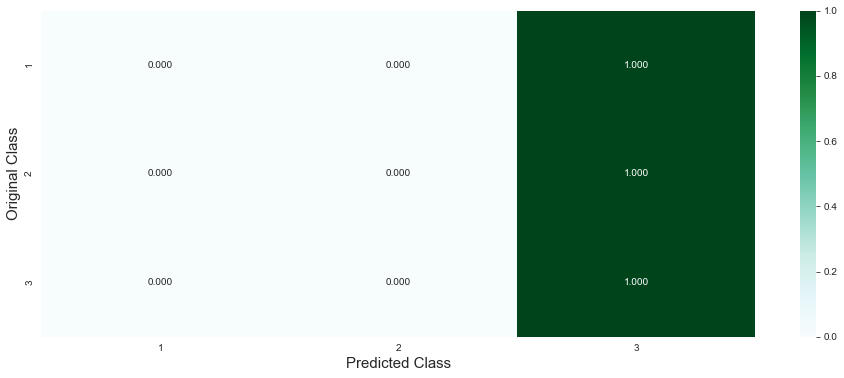

In [55]:
# params = {
#     'C':[0.001,0.01,0.1,1,10,100,1000],
#     'gamma':['scale','auto'],    
#          }

# svm = SVC(kernel='rbf',probability=True,class_weight='balanced')
# svm.fit(train_tfidf,train_labels)
# clf = GridSearchCV(svm,param_grid=params,scoring='f1_micro',cv=5,verbose=2,n_jobs=-1)
# clf.fit(train_bow,train_labels)

# print('Best Parameters : \n',clf.best_params_)
# print('Best score : \n',clf.best_score_)
# print('Best Estimator : \n',clf.best_estimator_)

# best_params = clf.best_params_
svm = SVC(kernel='rbf',probability=True,C=0.1,gamma='auto',class_weight='balanced')
svm.fit(train_tfidf,train_labels)

predict_train = svm.predict_proba(train_tfidf)
print("The train log loss is : ",log_loss(train_labels, predict_train, labels=svm.classes_, eps=1e-15))
predict_cv = svm.predict_proba(cv_tfidf)
print("The validation log loss is : ",log_loss(cv_labels, predict_cv, labels=svm.classes_, eps=1e-15))
predict_y = svm.predict_proba(test_tfidf)
print("The test log loss is : ",log_loss(test_labels, predict_y, labels=svm.classes_, eps=1e-15))

predict = svm.predict(test_tfidf)
acc_rbf_svm_tfidf = accuracy_score(test_labels,predict)
print('Accuracy :',acc_rbf_svm_tfidf)
miss_rbf_svm_tfidf = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_rbf_svm_tfidf = log_loss(test_labels, predict_y, labels=svm.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

Linear SVM :

The train log loss is :  0.13942764255906706
The validation log loss is :  0.5360826188659711
The test log loss is :  0.43875708670928987
Accuracy : 0.8295
Number of missclassified points :  341
Classification  Report :
               precision    recall  f1-score   support

           1       0.44      0.52      0.48       194
           2       0.20      0.18      0.19       114
           3       0.92      0.91      0.91      1692

    accuracy                           0.83      2000
   macro avg       0.52      0.54      0.53      2000
weighted avg       0.83      0.83      0.83      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


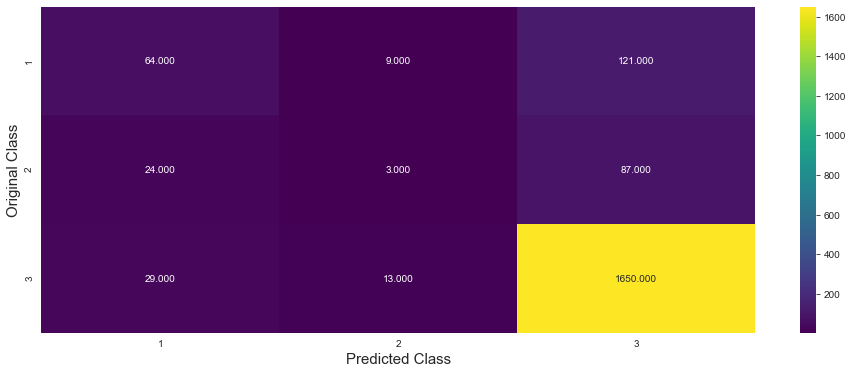



-------------------------------------------------- Precision matrix --------------------------------------------------


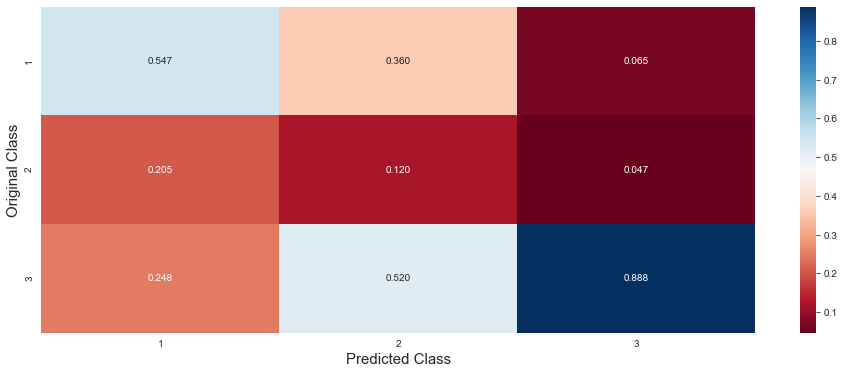



-------------------------------------------------- Recall matrix --------------------------------------------------


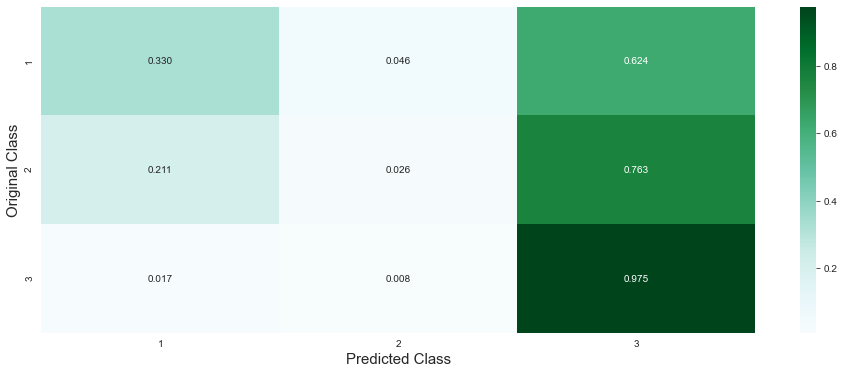

In [56]:
# params = {
#     'C':[0.01,0.1,1]
# #     'gamma':['scale','auto'],    
#          }

# svm = SVC(kernel='linear',probability=True,class_weight='balanced')
# svm.fit(train_bow,train_labels)
# clf = GridSearchCV(svm,param_grid=params,scoring='f1_micro',cv=5,verbose=2,n_jobs=-1)
# clf.fit(train_bow,train_labels)

# print('Best Parameters : \n',clf.best_params_)
# print('Best score : \n',clf.best_score_)
# print('Best Estimator : \n',clf.best_estimator_)

# best_params = clf.best_params_
svm = SVC(kernel='linear',probability=True,C=0.1,gamma='auto',class_weight='balanced')
svm.fit(train_bow,train_labels)

predict_train = svm.predict_proba(train_bow)
print("The train log loss is : ",log_loss(train_labels, predict_train, labels=svm.classes_, eps=1e-15))
predict_cv = svm.predict_proba(cv_bow)
print("The validation log loss is : ",log_loss(cv_labels, predict_cv, labels=svm.classes_, eps=1e-15))
predict_y = svm.predict_proba(test_bow)
print("The test log loss is : ",log_loss(test_labels, predict_y, labels=svm.classes_, eps=1e-15))

predict = svm.predict(test_bow)
acc_linear_svm_bow = accuracy_score(test_labels,predict)
print('Accuracy :',acc_linear_svm_bow)
miss_linear_svm_bow = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_linear_svm_bow = log_loss(test_labels, predict_y, labels=svm.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

The train log loss is :  0.22295856141135473
The validation log loss is :  0.48841747660163365
The test log loss is :  0.4150905960985136
Accuracy : 0.834
Number of missclassified points :  332
Classification  Report :
               precision    recall  f1-score   support

           1       0.45      0.47      0.46       194
           2       0.15      0.09      0.11       114
           3       0.91      0.93      0.92      1692

    accuracy                           0.83      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.82      0.83      0.83      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


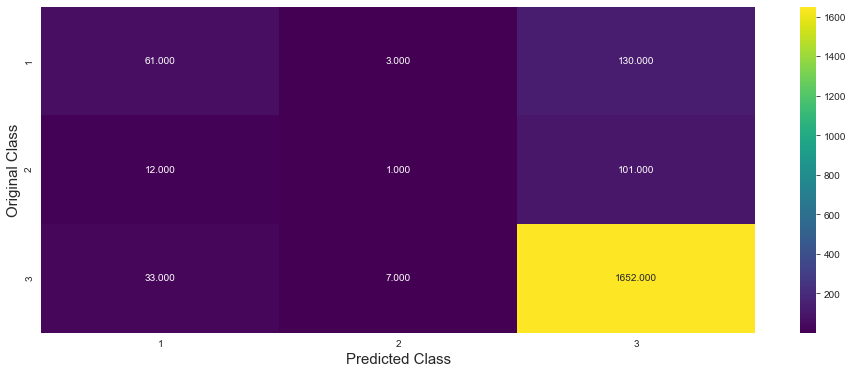



-------------------------------------------------- Precision matrix --------------------------------------------------


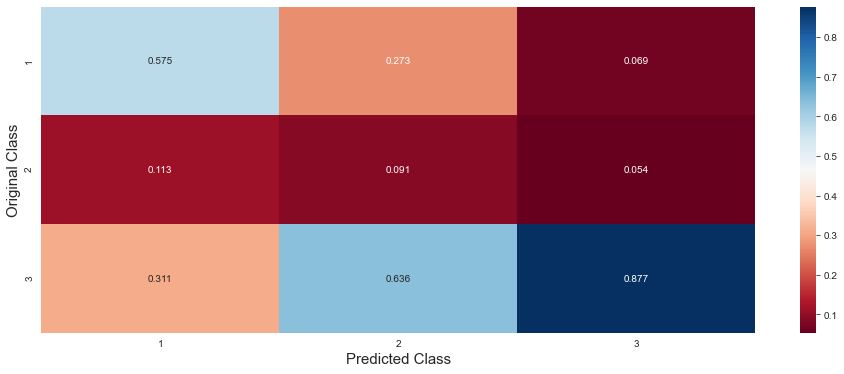



-------------------------------------------------- Recall matrix --------------------------------------------------


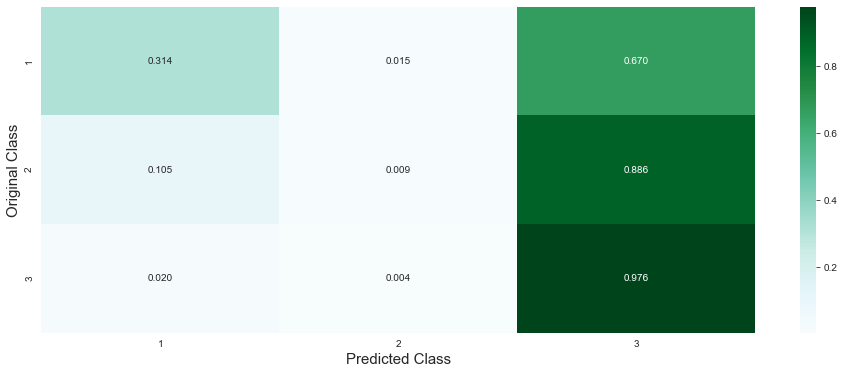

In [57]:
# params = {
#     'C':[0.001,0.01,0.1,1,10,100,1000],
#     'gamma':['scale','auto'],    
#          }

# svm = SVC(kernel='linear',probability=True,class_weight='balanced')
# svm.fit(train_tfidf,train_labels)
# clf = GridSearchCV(svm,param_grid=params,scoring='f1_micro',cv=5,verbose=2,n_jobs=-1)
# clf.fit(train_tfidf,train_labels)

# print('Best Parameters : \n',clf.best_params_)
# print('Best score : \n',clf.best_score_)
# print('Best Estimator : \n',clf.best_estimator_)

# best_params = clf.best_params_
svm = SVC(kernel='linear',probability=True,C=0.1,gamma='auto',class_weight='balanced')
svm.fit(train_tfidf,train_labels)

predict_train = svm.predict_proba(train_tfidf)
print("The train log loss is : ",log_loss(train_labels, predict_train, labels=svm.classes_, eps=1e-15))
predict_cv = svm.predict_proba(cv_tfidf)
print("The validation log loss is : ",log_loss(cv_labels, predict_cv, labels=svm.classes_, eps=1e-15))
predict_y = svm.predict_proba(test_tfidf)
print("The test log loss is : ",log_loss(test_labels, predict_y, labels=svm.classes_, eps=1e-15))

predict = svm.predict(test_tfidf)
acc_linear_svm_tfidf = accuracy_score(test_labels,predict)
print('Accuracy :',acc_linear_svm_tfidf)
miss_linear_svm_tfidf = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_linear_svm_tfidf = log_loss(test_labels, predict_y, labels=svm.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

GBDT :

The train log loss is :  0.0011623991584610127
The validation log loss is :  1.0245974496175239
The test log loss is :  0.7663758004456636
Accuracy : 0.8675
Number of missclassified points :  265
Classification  Report :
               precision    recall  f1-score   support

           1       0.69      0.31      0.43       194
           2       0.17      0.02      0.03       114
           3       0.88      0.99      0.93      1692

    accuracy                           0.87      2000
   macro avg       0.58      0.44      0.46      2000
weighted avg       0.82      0.87      0.83      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


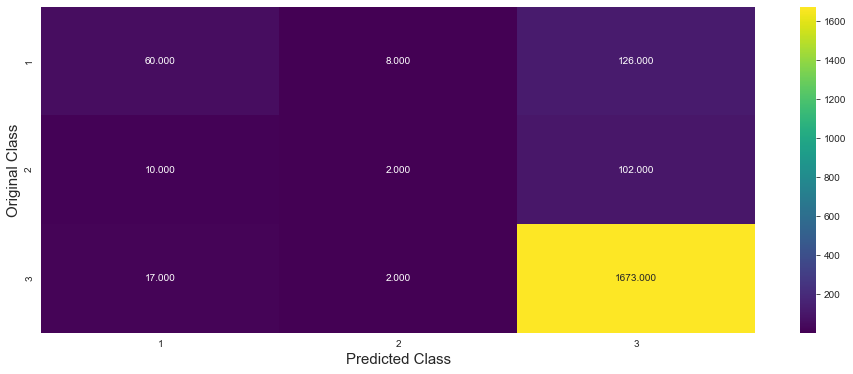



-------------------------------------------------- Precision matrix --------------------------------------------------


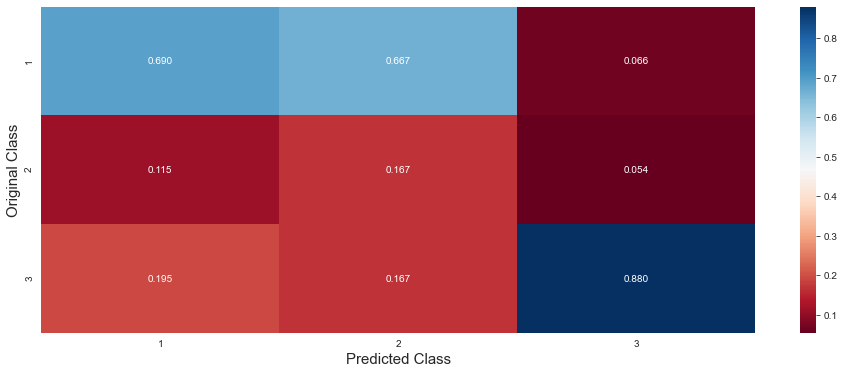



-------------------------------------------------- Recall matrix --------------------------------------------------


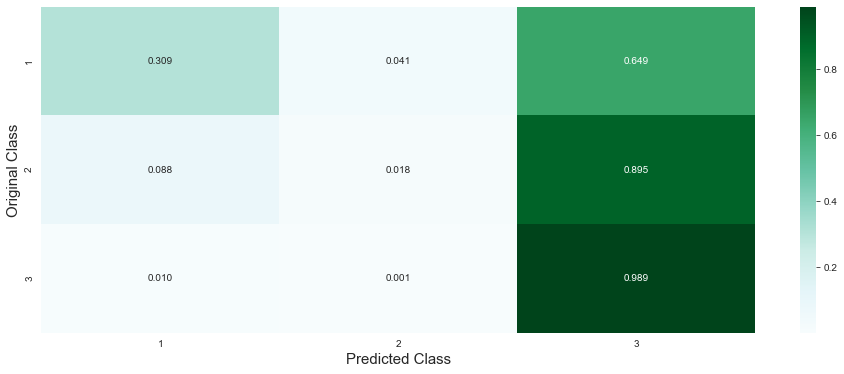

In [58]:
# params = {
#     'learning_rate':[0.01,0.1,1,10],
#          'n_estimators' : [2,5,10,50,100,200,500]
#          'max_depth' : [2,5,10,50,70,100],
#          'min_samples_leaf':[1,2,5,8,10],
#          'subsample':[0.1,0.5,0.8,1]
#          }

# gbdt = GradientBoostingClassifier(learning_rate=0.1,n_estimators=100,max_depth=100)
# gbdt.fit(train_bow,train_labels)
# clf = GridSearchCV(gbdt,param_grid=params,scoring='f1_micro',cv=5,verbose=2,n_jobs=-1)
# clf.fit(train_bow,train_labels)

# print('Best Parameters : \n',clf.best_params_)
# print('Best score : \n',clf.best_score_)
# print('Best Estimator : \n',clf.best_estimator_)

# best_params = clf.best_params_
gbdt = GradientBoostingClassifier(learning_rate = 0.1,n_estimators=100,max_depth=100,min_samples_leaf=5,subsample=0.8)
gbdt.fit(train_bow,train_labels)

predict_train = gbdt.predict_proba(train_bow)
print("The train log loss is : ",log_loss(train_labels, predict_train, labels=gbdt.classes_, eps=1e-15))
predict_cv = gbdt.predict_proba(cv_bow)
print("The validation log loss is : ",log_loss(cv_labels, predict_cv, labels=gbdt.classes_, eps=1e-15))
predict_y = gbdt.predict_proba(test_bow)
print("The test log loss is : ",log_loss(test_labels, predict_y, labels=gbdt.classes_, eps=1e-15))

predict = gbdt.predict(test_bow)
acc_gbdt_bow = accuracy_score(test_labels,predict)
print('Accuracy :',acc_gbdt_bow)
miss_gbdt_bow = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_gbdt_bow = log_loss(test_labels, predict_y, labels=gbdt.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

GBDT with BOW is overfitting

The train log loss is :  0.0010826074216029333
The validation log loss is :  1.0907583637445089
The test log loss is :  0.8288886451835598
Accuracy : 0.8625
Number of missclassified points :  275
Classification  Report :
               precision    recall  f1-score   support

           1       0.61      0.32      0.42       194
           2       0.15      0.03      0.04       114
           3       0.88      0.98      0.93      1692

    accuracy                           0.86      2000
   macro avg       0.55      0.44      0.46      2000
weighted avg       0.82      0.86      0.83      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


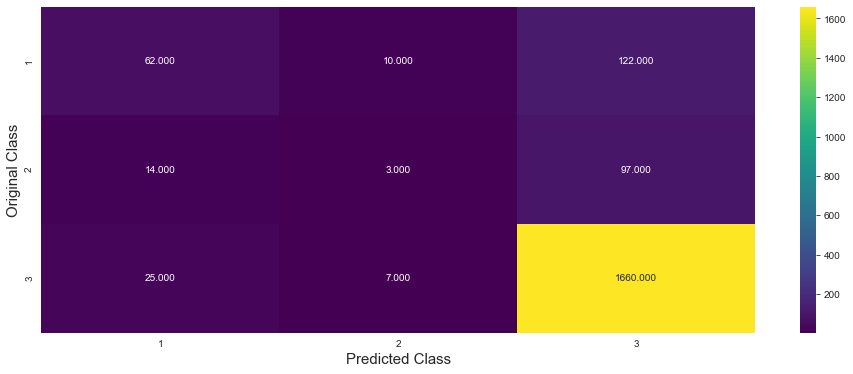



-------------------------------------------------- Precision matrix --------------------------------------------------


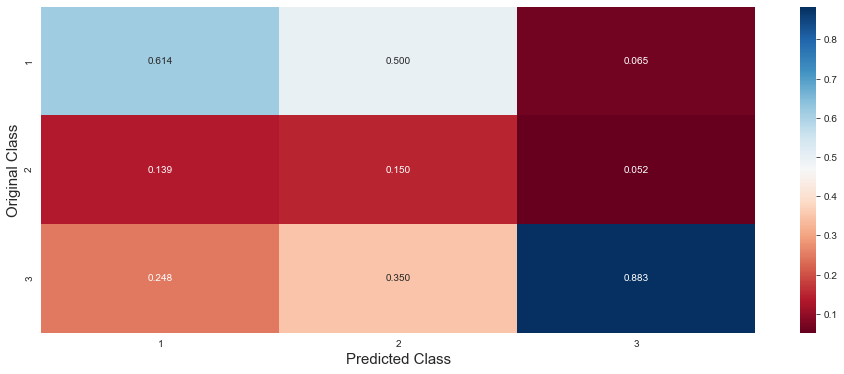



-------------------------------------------------- Recall matrix --------------------------------------------------


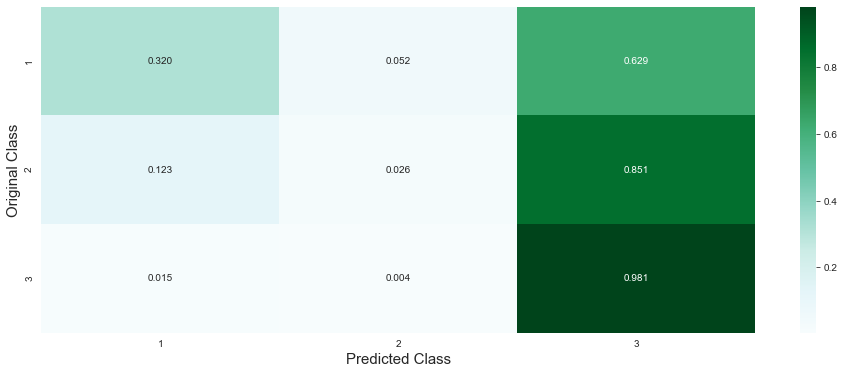

In [59]:
# params = {'learning_rate':[0.01,0.1,1,10],
#          'n_estimators' : [2,5,10,50,100],
#          'max_depth' : [2,5,10,50,100],
#          'min_samples_leaf':[1,2,5,8,10],
#          'subsample':[0.1,0.5,0.8,1]
#          }

# gbdt = GradientBoostingClassifier()
# gbdt.fit(train_tfidf,train_labels)
# clf = GridSearchCV(gbdt,param_grid=params,scoring='f1_micro',cv=10,verbose=2,n_jobs=-1)
# clf.fit(train_tfidf,train_labels)

# print('Best Parameters : \n',clf.best_params)
# print('Best score : \n',clf.best_score_)
# print('Best Estimator : \n',clf.best_estimator_)
# best_params = clf.best_params_

gbdt = GradientBoostingClassifier(learning_rate = 0.1,n_estimators=100,max_depth=100,min_samples_leaf=5,subsample=0.8)
gbdt.fit(train_tfidf,train_labels)

predict_train = gbdt.predict_proba(train_tfidf)
print("The train log loss is : ",log_loss(train_labels, predict_train, labels=gbdt.classes_, eps=1e-15))
predict_cv = gbdt.predict_proba(cv_tfidf)
print("The validation log loss is : ",log_loss(cv_labels, predict_cv, labels=gbdt.classes_, eps=1e-15))
predict_y = gbdt.predict_proba(test_tfidf)
print("The test log loss is : ",log_loss(test_labels, predict_y, labels=gbdt.classes_, eps=1e-15))

predict = gbdt.predict(test_tfidf)
acc_gbdt_tfidf = accuracy_score(test_labels,predict)
print('Accuracy :',acc_gbdt_tfidf)
miss_gbdt_tfidf = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_gbdt_tfidf = log_loss(test_labels, predict_y, labels=gbdt.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

GBDT with TF-IDF is overfitting

Random Forest :

The train log loss is :  0.4186552861046756
The validation log loss is :  0.6279177516596256
The test log loss is :  0.6023068848261776
Accuracy : 0.8455
Number of missclassified points :  309
Classification  Report :
               precision    recall  f1-score   support

           1       0.45      0.42      0.44       194
           2       0.50      0.01      0.02       114
           3       0.89      0.95      0.92      1692

    accuracy                           0.85      2000
   macro avg       0.61      0.46      0.46      2000
weighted avg       0.82      0.85      0.82      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


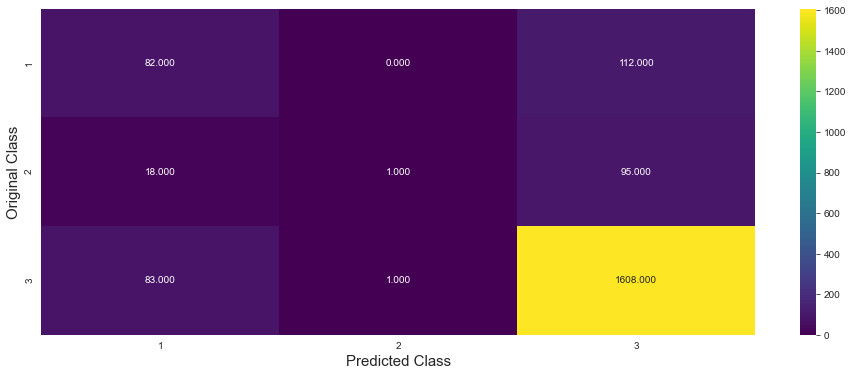



-------------------------------------------------- Precision matrix --------------------------------------------------


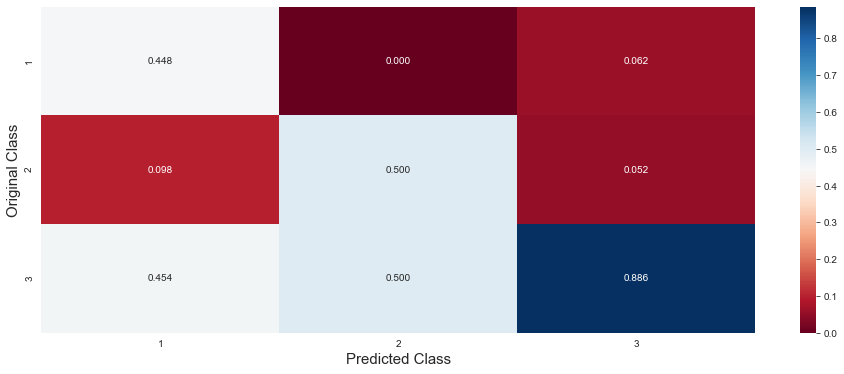



-------------------------------------------------- Recall matrix --------------------------------------------------


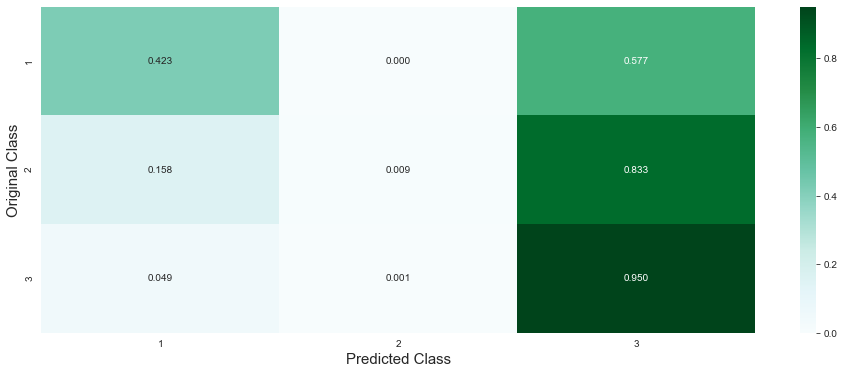

In [60]:
# params = {
#     'criterion':['gini','entropy'],
#          'n_estimators' : [2,5,10,50,100,200,500],
#          'max_depth' : [2,5,10,50,70,100],
#          'min_samples_leaf':[1,2,5,8,10]
#          }

# rf = RandomForestClassifier(class_weight='balanced')
# rf.fit(train_bow,train_labels)
# clf = GridSearchCV(rf,param_grid=params,scoring='f1_micro',cv=5,verbose=2,n_jobs=-1)
# clf.fit(train_bow,train_labels)

# print('Best Parameters : \n',clf.best_params_)
# print('Best score : \n',clf.best_score_)
# print('Best Estimator : \n',clf.best_estimator_)

# best_params = clf.best_params_
rf = RandomForestClassifier(criterion='entropy',n_estimators=500,max_depth=70,min_samples_leaf=2,class_weight='balanced')
rf.fit(train_bow,train_labels)

predict_train = rf.predict_proba(train_bow)
print("The train log loss is : ",log_loss(train_labels, predict_train, labels=rf.classes_, eps=1e-15))
predict_cv = rf.predict_proba(cv_bow)
print("The validation log loss is : ",log_loss(cv_labels, predict_cv, labels=rf.classes_, eps=1e-15))
predict_y = rf.predict_proba(test_bow)
print("The test log loss is : ",log_loss(test_labels, predict_y, labels=rf.classes_, eps=1e-15))

predict = rf.predict(test_bow)
acc_rf_bow = accuracy_score(test_labels,predict)
print('Accuracy :',acc_rf_bow)
miss_rf_bow = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_rf_bow = log_loss(test_labels, predict_y, labels=rf.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

The train log loss is :  0.3876237055055144
The validation log loss is :  0.6119853854216248
The test log loss is :  0.5819835584045545
Accuracy : 0.854
Number of missclassified points :  292
Classification  Report :
               precision    recall  f1-score   support

           1       0.53      0.32      0.40       194
           2       0.25      0.01      0.02       114
           3       0.88      0.97      0.92      1692

    accuracy                           0.85      2000
   macro avg       0.55      0.44      0.45      2000
weighted avg       0.81      0.85      0.82      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


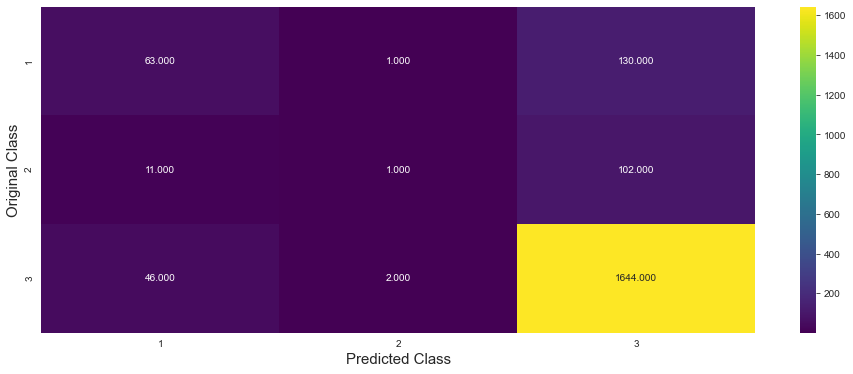



-------------------------------------------------- Precision matrix --------------------------------------------------


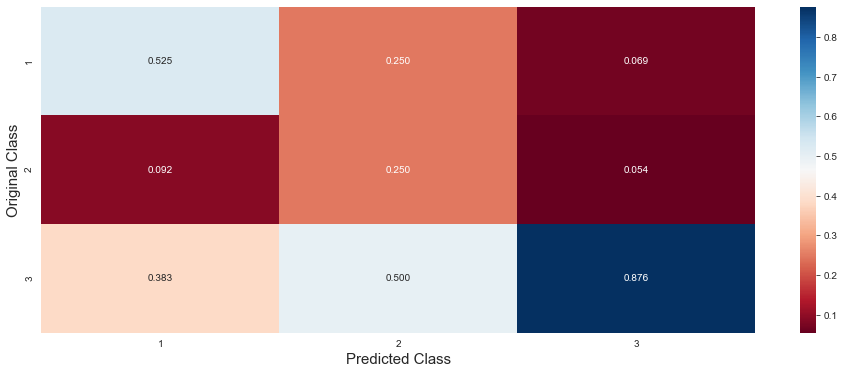



-------------------------------------------------- Recall matrix --------------------------------------------------


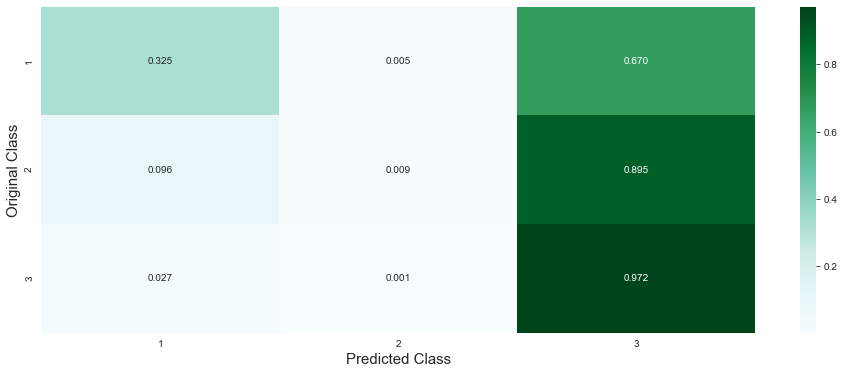

In [61]:
# params = {
#     'criterion':['gini','entropy'],
#          'n_estimators' : [2,5,10,50,100,200,500],
#          'max_depth' : [2,5,10,50,70,100],
#          'min_samples_leaf':[1,2,5,8,10]
#          }

# rf = RandomForestClassifier(class_weight='balanced')
# rf.fit(train_tfidf,train_labels)
# clf = GridSearchCV(rf,param_grid=params,scoring='f1_micro',cv=5,verbose=2,n_jobs=-1)
# clf.fit(train_tfidf,train_labels)

# print('Best Parameters : \n',clf.best_params_)
# print('Best score : \n',clf.best_score_)
# print('Best Estimator : \n',clf.best_estimator_)

# best_params = clf.best_params_
rf = RandomForestClassifier(criterion='entropy',n_estimators=500,max_depth=70,min_samples_leaf=2,class_weight='balanced')
rf.fit(train_tfidf,train_labels)

predict_train = rf.predict_proba(train_tfidf)
print("The train log loss is : ",log_loss(train_labels, predict_train, labels=rf.classes_, eps=1e-15))
predict_cv = rf.predict_proba(cv_tfidf)
print("The validation log loss is : ",log_loss(cv_labels, predict_cv, labels=rf.classes_, eps=1e-15))
predict_y = rf.predict_proba(test_tfidf)
print("The test log loss is : ",log_loss(test_labels, predict_y, labels=rf.classes_, eps=1e-15))

predict = rf.predict(test_tfidf)
acc_rf_tfidf = accuracy_score(test_labels,predict)
print('Accuracy :',acc_rf_tfidf)
miss_rf_tfidf = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_rf_tfidf = log_loss(test_labels, predict_y, labels=rf.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

KNN : 

The train log loss is :  0.30742191132613383
The validation log loss is :  2.9275664942800628
The test log loss is :  2.2334980269197904
Accuracy : 0.841
Number of missclassified points :  318
Classification  Report :
               precision    recall  f1-score   support

           1       0.33      0.04      0.07       194
           2       0.30      0.03      0.05       114
           3       0.85      0.99      0.91      1692

    accuracy                           0.84      2000
   macro avg       0.49      0.35      0.34      2000
weighted avg       0.77      0.84      0.78      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


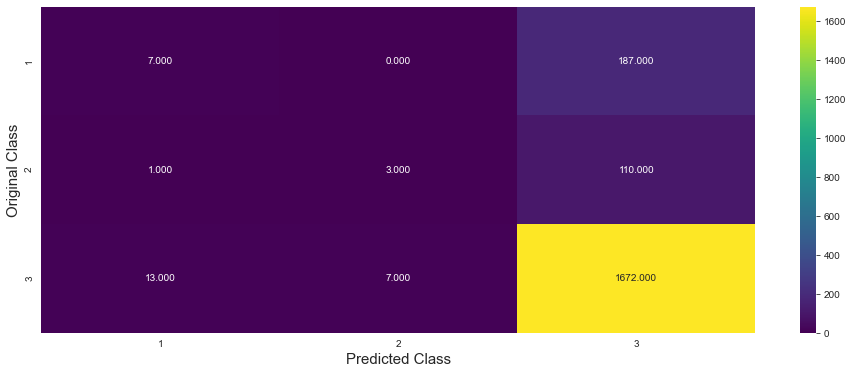



-------------------------------------------------- Precision matrix --------------------------------------------------


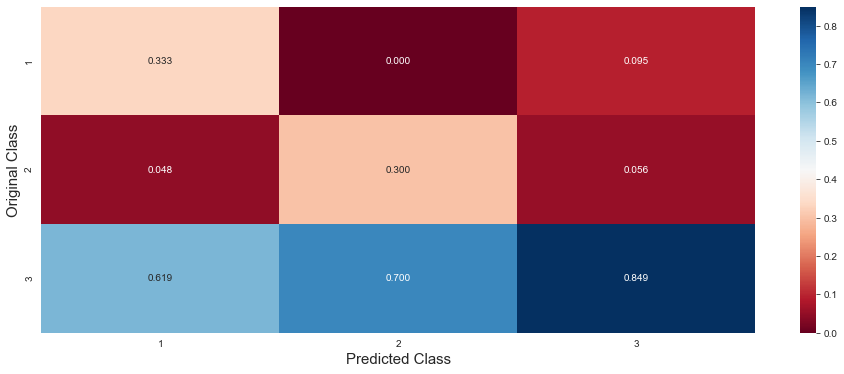



-------------------------------------------------- Recall matrix --------------------------------------------------


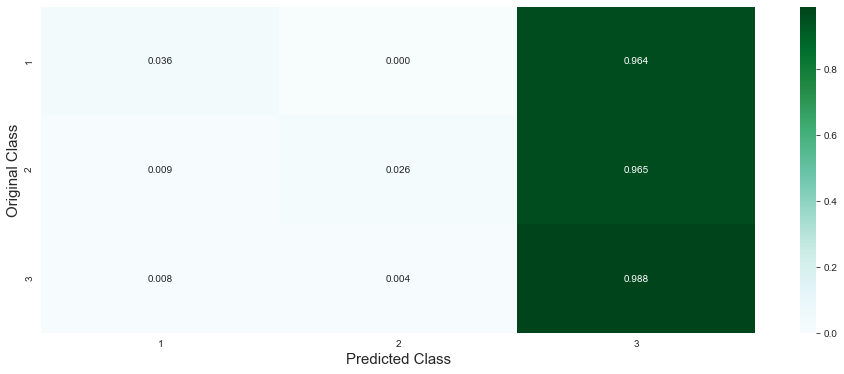

In [62]:
# params = {
#     'n_neighbors':[1,2,3,4,5,6,7,8,9,10],
#        'algorithm':['kd-tree','auto','brute'],
#         'leaf_size':[2,5,10,20,30,50,70,100],
#          }

# knn = KNeighborsClassifier()
# knn.fit(train_bow,train_labels)
# clf = GridSearchCV(knn,param_grid=params,scoring='f1_micro',cv=5,verbose=2,n_jobs=-1)
# clf.fit(train_bow,train_labels)

# print('Best Parameters : \n',clf.best_params_)
# print('Best score : \n',clf.best_score_)
# print('Best Estimator : \n',clf.best_estimator_)

# best_params = clf.best_params_
knn = KNeighborsClassifier(algorithm='auto',leaf_size=2,n_neighbors=9)
knn.fit(train_bow,train_labels)

predict_train = knn.predict_proba(train_bow)
print("The train log loss is : ",log_loss(train_labels, predict_train, labels=knn.classes_, eps=1e-15))
predict_cv = knn.predict_proba(cv_bow)
print("The validation log loss is : ",log_loss(cv_labels, predict_cv, labels=knn.classes_, eps=1e-15))
predict_y = knn.predict_proba(test_bow)
print("The test log loss is : ",log_loss(test_labels, predict_y, labels=knn.classes_, eps=1e-15))

predict = knn.predict(test_bow)
acc_knn_bow = accuracy_score(test_labels,predict)
print('Accuracy :',acc_knn_bow)
miss_knn_bow = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_knn_bow = log_loss(test_labels, predict_y, labels=knn.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

The train log loss is :  0.3245395248387051
The validation log loss is :  2.0387697027787097
The test log loss is :  2.0255587330027782
Accuracy : 0.848
Number of missclassified points :  304
Classification  Report :
               precision    recall  f1-score   support

           1       0.53      0.23      0.32       194
           2       0.17      0.04      0.06       114
           3       0.87      0.97      0.92      1692

    accuracy                           0.85      2000
   macro avg       0.52      0.41      0.43      2000
weighted avg       0.80      0.85      0.81      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


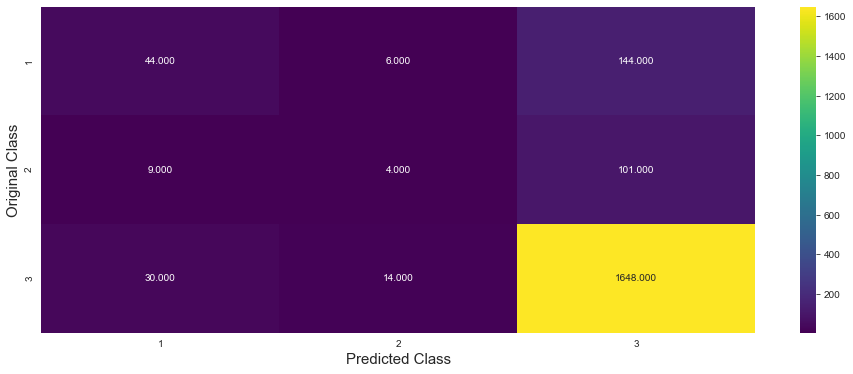



-------------------------------------------------- Precision matrix --------------------------------------------------


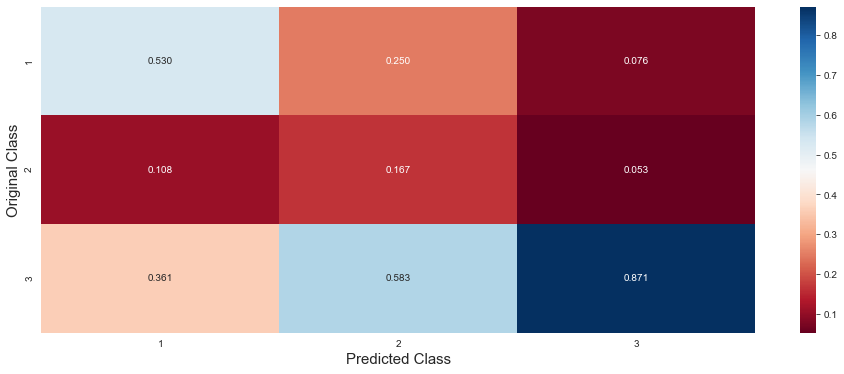



-------------------------------------------------- Recall matrix --------------------------------------------------


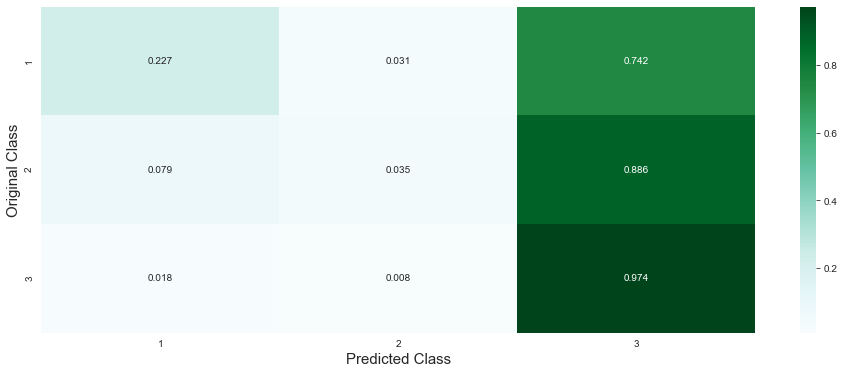

In [63]:
# params = {
#     'n_neighbors':[1,2,3,4,5,6,7,8,9,10],
#        'algorithm':['kd-tree','auto','brute'],
#         'leaf_size':[2,5,10,20,30,50,70,100],
#          }

# knn = KNeighborsClassifier()
# knn.fit(train_tfidf,train_labels)
# clf = GridSearchCV(knn,param_grid=params,scoring='f1_micro',cv=5,verbose=2,n_jobs=-1)
# clf.fit(train_tfidf,train_labels)

# print('Best Parameters : \n',clf.best_params_)
# print('Best score : \n',clf.best_score_)
# print('Best Estimator : \n',clf.best_estimator_)

# best_params = clf.best_params_
knn = KNeighborsClassifier(algorithm='auto',leaf_size=2,n_neighbors=9)
knn.fit(train_tfidf,train_labels)

predict_train = knn.predict_proba(train_tfidf)
print("The train log loss is : ",log_loss(train_labels, predict_train, labels=knn.classes_, eps=1e-15))
predict_cv = knn.predict_proba(cv_tfidf)
print("The validation log loss is : ",log_loss(cv_labels, predict_cv, labels=knn.classes_, eps=1e-15))
predict_y = knn.predict_proba(test_tfidf)
print("The test log loss is : ",log_loss(test_labels, predict_y, labels=knn.classes_, eps=1e-15))

predict = knn.predict(test_tfidf)
acc_knn_tfidf = accuracy_score(test_labels,predict)
print('Accuracy :',acc_knn_tfidf)
miss_knn_tfidf = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_knn_tfidf = log_loss(test_labels, predict_y, labels=knn.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

XGBoost : 


The train log loss is :  0.19438588543381344
The validation log loss is :  0.4507310099809365
The test log loss is :  0.4021424974201218
Accuracy : 0.8645
Number of missclassified points :  271
Classification  Report :
               precision    recall  f1-score   support

           1       0.75      0.23      0.35       194
           2       0.37      0.06      0.11       114
           3       0.87      0.99      0.93      1692

    accuracy                           0.86      2000
   macro avg       0.66      0.43      0.46      2000
weighted avg       0.83      0.86      0.83      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


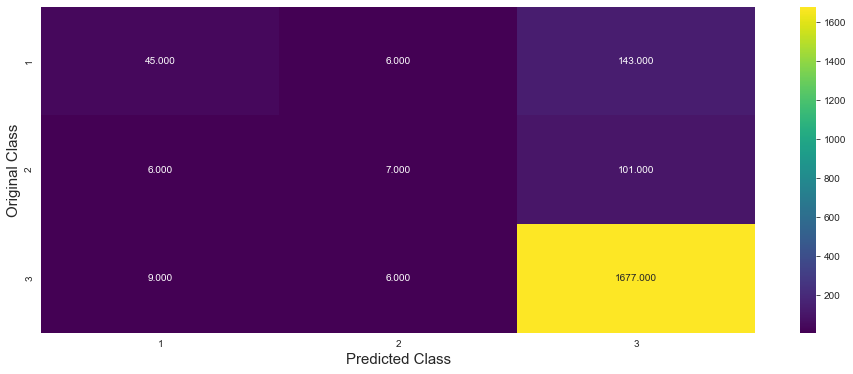



-------------------------------------------------- Precision matrix --------------------------------------------------


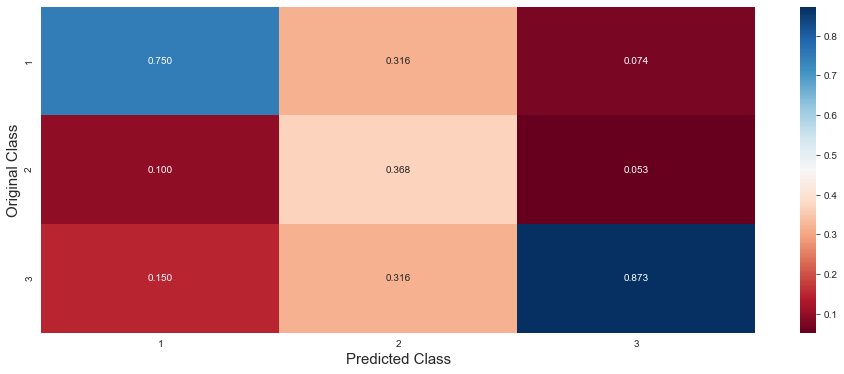



-------------------------------------------------- Recall matrix --------------------------------------------------


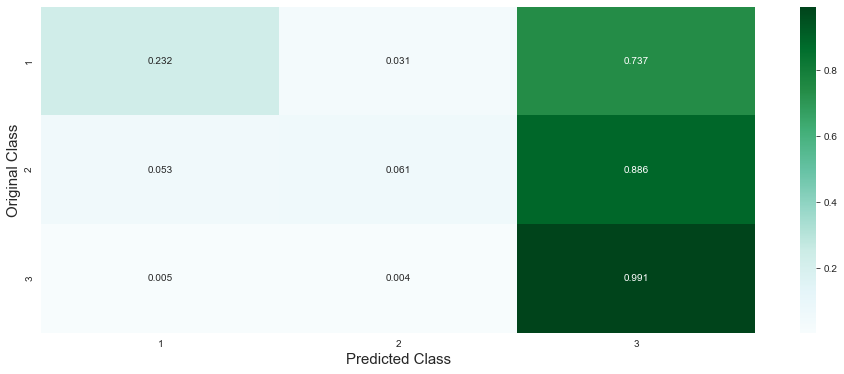

In [64]:
# params = {
# #     'booster':['gbtree'],
# #     'eta':[0.01,0.1,0.3,0.5,0.7,0.9],
# #     'gamma':[0,0.3,0.5,0.8],
# #     'max_depth':[2,5,10,20,40,70],
# #     'min_child_weight':[1,3,5,7,9,11,15],
#     'subsample':[0.1,0.3,0.5,0.6,0.8,1],
# #     'colsample_bytree':[0.6,0.8,1],
# #     'reg_lambda':[0.01,0.1,1,10],
# #     'reg_alpha':[0.01,0.1,1,10],
# #     'max_leaves':[1,2,3,5],
#          }

# xg = xgb.XGBClassifier(booster='gbtree',eta=0.01,gamma=0.8,max_depth=40,min_child_weight=3)
# xg.fit(train_bow,train_labels)
# clf = GridSearchCV(xg,param_grid=params,scoring='f1_micro',cv=5,verbose=2,n_jobs=-1)
# clf.fit(train_bow,train_labels)

# print('Best Parameters : \n',clf.best_params_)
# print('Best score : \n',clf.best_score_)
# print('Best Estimator : \n',clf.best_estimator_)

# best_params = clf.best_params_
xg = xgb.XGBClassifier(booster='gbtree',
    eta=0.3,
    gamma=0.3,
    max_depth=5,
    min_child_weight=5,
    subsample=0.8,   
    colsample_bytree=0.8,
    reg_lambda=0.3,
    reg_alpha=0.3,
    max_leaves=5)
xg.fit(train_bow,train_labels)

predict_train = xg.predict_proba(train_bow)
print("The train log loss is : ",log_loss(train_labels, predict_train, labels=xg.classes_, eps=1e-15))
predict_cv = xg.predict_proba(cv_bow)
print("The validation log loss is : ",log_loss(cv_labels, predict_cv, labels=xg.classes_, eps=1e-15))
predict_y = xg.predict_proba(test_bow)
print("The test log loss is : ",log_loss(test_labels, predict_y, labels=xg.classes_, eps=1e-15))

predict = xg.predict(test_bow)
acc_xgb_bow = accuracy_score(test_labels,predict)
print('Accuracy :',acc_xgb_bow)
miss_xgb_bow = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_xgb_bow = log_loss(test_labels, predict_y, labels=xg.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

The train log loss is :  0.15672469039597445
The validation log loss is :  0.4924164534715237
The test log loss is :  0.39894252779138334
Accuracy : 0.869
Number of missclassified points :  262
Classification  Report :
               precision    recall  f1-score   support

           1       0.73      0.30      0.43       194
           2       0.39      0.06      0.11       114
           3       0.88      0.99      0.93      1692

    accuracy                           0.87      2000
   macro avg       0.67      0.45      0.49      2000
weighted avg       0.84      0.87      0.84      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


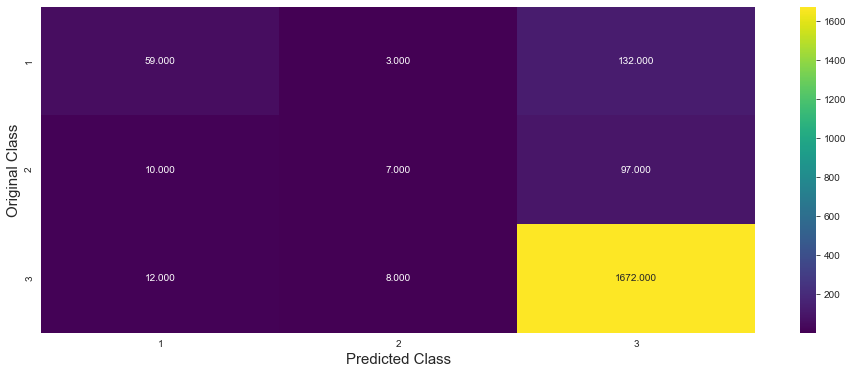



-------------------------------------------------- Precision matrix --------------------------------------------------


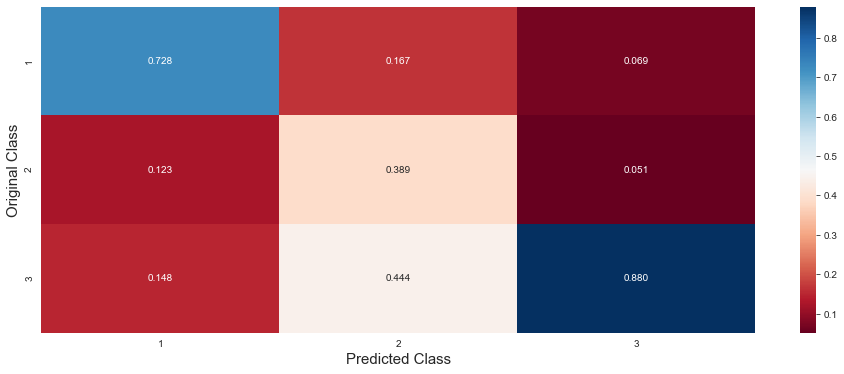



-------------------------------------------------- Recall matrix --------------------------------------------------


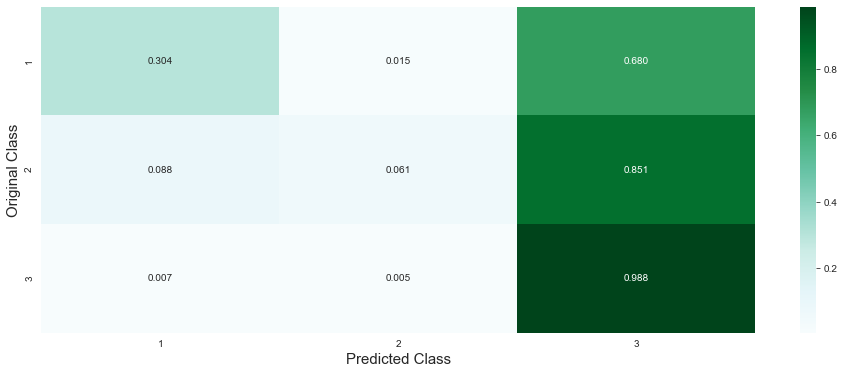

In [65]:
# params = {
# #     'booster':['gbtree'],
# #     'eta':[0.01,0.1,0.3,0.5,0.7,0.9],
# #     'gamma':[0,0.3,0.5,0.8],
# #     'max_depth':[2,5,10,20,40,70],
# #     'min_child_weight':[1,3,5,7,9,11,15],
#     'subsample':[0.1,0.3,0.5,0.6,0.8,1],
# #     'colsample_bytree':[0.6,0.8,1],
# #     'reg_lambda':[0.01,0.1,1,10],
# #     'reg_alpha':[0.01,0.1,1,10],
# #     'max_leaves':[1,2,3,5],
#          }

# xg = xgb.XGBClassifier(booster='gbtree',eta=0.01,gamma=0.8,max_depth=40,min_child_weight=3)
# xg.fit(train_tfidf,train_labels)
# clf = GridSearchCV(xg,param_grid=params,scoring='f1_micro',cv=5,verbose=2,n_jobs=-1)
# clf.fit(train_tfidf,train_labels)

# print('Best Parameters : \n',clf.best_params_)
# print('Best score : \n',clf.best_score_)
# print('Best Estimator : \n',clf.best_estimator_)

# best_params = clf.best_params_
xg = xgb.XGBClassifier(booster='gbtree',
    eta=0.3,
    gamma=0.3,
    max_depth=5,
    min_child_weight=5,
    subsample=0.8,   
    colsample_bytree=0.8,
    reg_lambda=0.3,
    reg_alpha=0.3,
    max_leaves=5)
xg.fit(train_tfidf,train_labels)

predict_train = xg.predict_proba(train_tfidf)
print("The train log loss is : ",log_loss(train_labels, predict_train, labels=xg.classes_, eps=1e-15))
predict_cv = xg.predict_proba(cv_tfidf)
print("The validation log loss is : ",log_loss(cv_labels, predict_cv, labels=xg.classes_, eps=1e-15))
predict_y = xg.predict_proba(test_tfidf)
print("The test log loss is : ",log_loss(test_labels, predict_y, labels=xg.classes_, eps=1e-15))

predict = xg.predict(test_tfidf)
acc_xgb_tfidf = accuracy_score(test_labels,predict)
print('Accuracy :',acc_xgb_tfidf)
miss_xgb_tfidf = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_xgb_tfidf = log_loss(test_labels, predict_y, labels=xg.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

Light GBM :

[LightGBM] [Warning] Unknown parameter: booster
The train log loss is :  0.021993270478787547
The validation log loss is :  0.6523468975457974
The test log loss is :  0.5142643309841003
Accuracy : 0.8505
Number of missclassified points :  299
Classification  Report :
               precision    recall  f1-score   support

           1       0.48      0.40      0.44       194
           2       0.34      0.18      0.23       114
           3       0.90      0.95      0.92      1692

    accuracy                           0.85      2000
   macro avg       0.57      0.51      0.53      2000
weighted avg       0.83      0.85      0.84      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


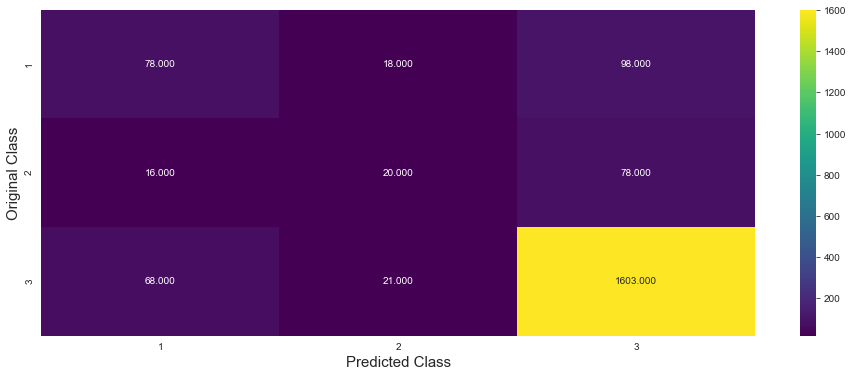



-------------------------------------------------- Precision matrix --------------------------------------------------


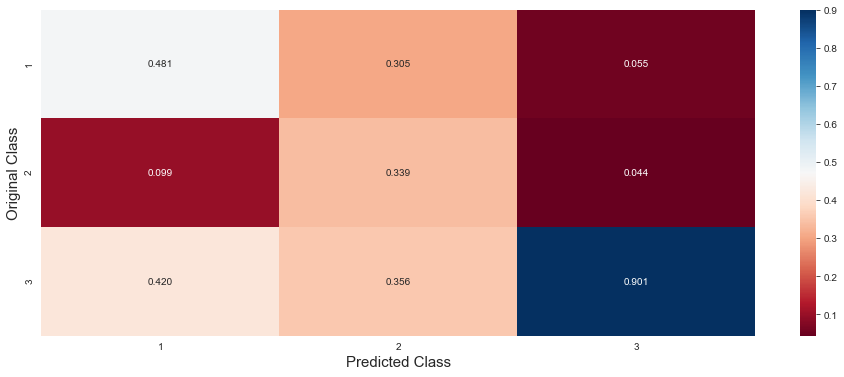



-------------------------------------------------- Recall matrix --------------------------------------------------


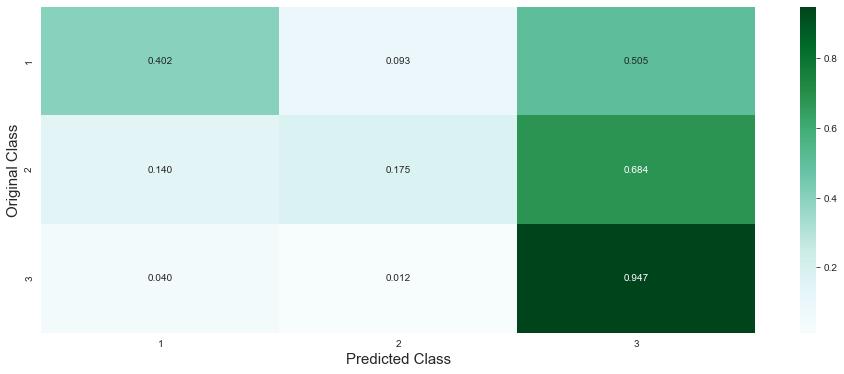

In [66]:
X_train_bow = train_bow.astype('float32')
X_test_bow = test_bow.astype('float32')
X_cv_bow = cv_bow.astype('float32')   
Y_train = train_labels.astype('float32')
Y_cv = cv_labels.astype('float32')
Y_test = test_labels.astype('float32')

# params = {
#     'booster':['gbdt','rf'],
#     'learning_rate':[0.01,0.1,0.3,0.5,0.7,0.9],
#     'n_estimators':[2,4,10,30,50,100,200],
#     'subsample':[0.2,0.3,0.5,0.8,1],
#     'max_depth':[2,5,10,20,40,70],
#     'min_child_weight':[1,3,5,7,9,11,15],
#     'colsample_bytree':[0.6,0.8,1],
#     'reg_lambda':[0.01,0.1,1,10],
#     'reg-alpha':[0.01,0.1,1,10],
#     'num_leaves':[1,2,3,5,10,20,50,100],
#          }

# lg = lgb.LGBMClassifier(class_weight='balanced')
# lg.fit(X_train_bow,Y_train)
# clf = GridSearchCV(lg,param_grid=params,scoring='f1_micro',cv=5,verbose=2,n_jobs=-1)
# clf.fit(X_train_bow,Y_train)

# print('Best Parameters : \n',clf.best_params_)
# print('Best score : \n',clf.best_score_)
# print('Best Estimator : \n',clf.best_estimator_)

# best_params = clf.best_params_
lg = lgb.LGBMClassifier(class_weight='balanced',
                        booster='gbdt',
                        learning_rate=0.7,
                        n_estimators=40,
                        subsample=0.2,
                        num_leaves=100,
                        max_depth=40,
                        min_child_weight=1 , 
                        colsample_bytree=0.8,
                        reg_lambda=0.2,
                        reg_alpha=0.2,)
lg.fit(X_train_bow,Y_train)

predict_train = lg.predict_proba(X_train_bow)
print("The train log loss is : ",log_loss(Y_train, predict_train, labels=lg.classes_, eps=1e-15))
predict_cv = lg.predict_proba(X_cv_bow)
print("The validation log loss is : ",log_loss(Y_cv, predict_cv, labels=lg.classes_, eps=1e-15))
predict_y = lg.predict_proba(X_test_bow)
print("The test log loss is : ",log_loss(Y_test ,predict_y, labels=lg.classes_, eps=1e-15))

predict = lg.predict(X_test_bow)
acc_lgb_bow = accuracy_score(test_labels,predict)
print('Accuracy :',acc_lgb_bow)
miss_lgb_bow = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_lgb_bow = log_loss(Y_test, predict_y, labels=lg.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

[LightGBM] [Warning] Unknown parameter: booster
The train log loss is :  0.012012041206783931
The validation log loss is :  0.6864273595956392
The test log loss is :  0.5401136710154958
Accuracy : 0.853
Number of missclassified points :  294
Classification  Report :
               precision    recall  f1-score   support

           1       0.48      0.39      0.43       194
           2       0.30      0.15      0.20       114
           3       0.90      0.95      0.93      1692

    accuracy                           0.85      2000
   macro avg       0.56      0.50      0.52      2000
weighted avg       0.83      0.85      0.84      2000



-------------------------------------------------- Confusion matrix --------------------------------------------------


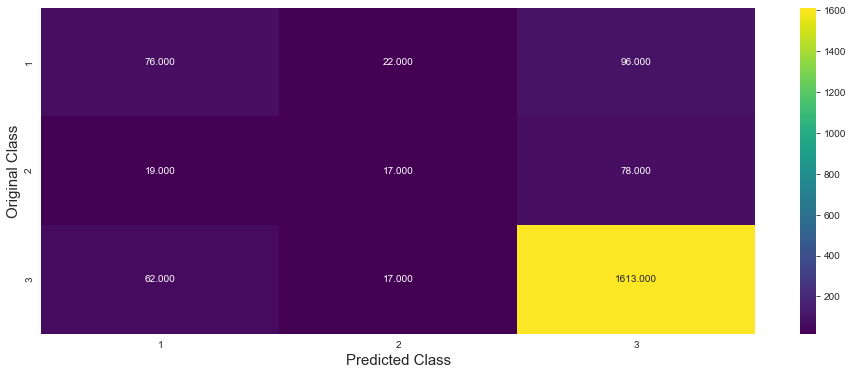



-------------------------------------------------- Precision matrix --------------------------------------------------


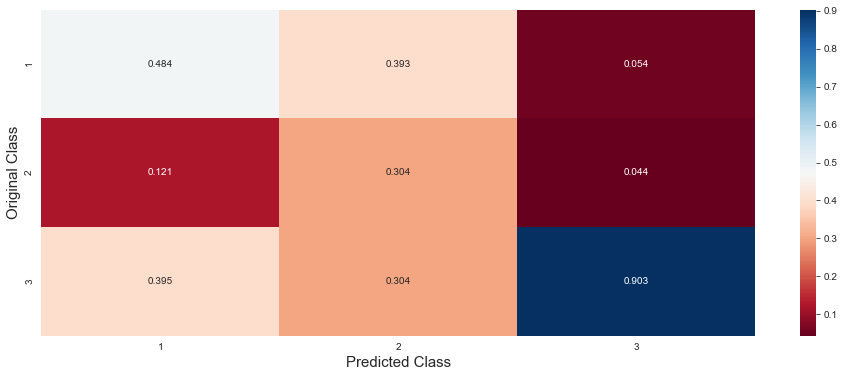



-------------------------------------------------- Recall matrix --------------------------------------------------


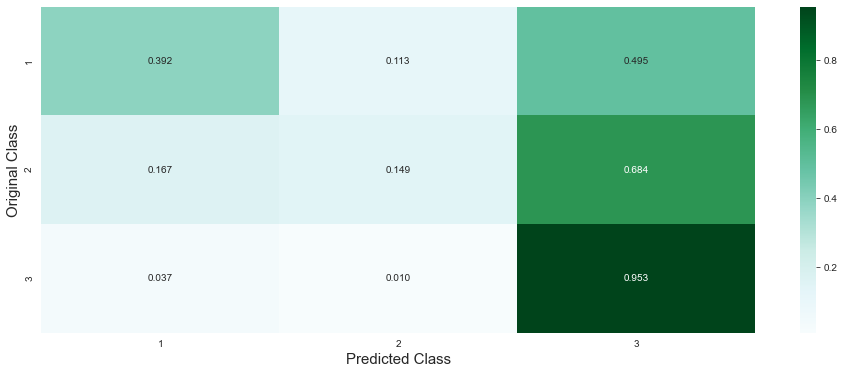

In [67]:
X_train_tfidf = train_tfidf.astype('float32')
X_test_tfidf = test_tfidf.astype('float32')
X_cv_tfidf = cv_tfidf.astype('float32')

# params = {
#     'booster':['gbdt','rf'],
#     'learning_rate':[0.01,0.1,0.3,0.5,0.7,0.9],
#     'n_estimators':[2,4,10,30,50,100,200],
#     'subsample':[0.2,0.3,0.5,0.8,1],
#     'max_depth':[2,5,10,20,40,70],
#     'min_child_weight':[1,3,5,7,9,11,15],
#     'colsample_bytree':[0.6,0.8,1],
#     'reg_lambda':[0.01,0.1,1,10],
#     'reg-alpha':[0.01,0.1,1,10],
#     'num_leaves':[1,2,3,5,10,20,50,100],
#          }

# lg = lgb.LGBMClassifier(class_weight='balanced')
# lg.fit(X_train_tfidf,Y_train)
# clf = GridSearchCV(lg,param_grid=params,scoring='f1_micro',cv=5,verbose=2,n_jobs=-1)
# clf.fit(X_train_tfidf,Y_train)

# print('Best Parameters : \n',clf.best_params_)
# print('Best score : \n',clf.best_score_)
# print('Best Estimator : \n',clf.best_estimator_)

# best_params = clf.best_params_
lg = lgb.LGBMClassifier(class_weight='balanced',
                        booster='gbdt',
                        learning_rate=0.7,
                        n_estimators=40,
                        subsample=0.2,
                        num_leaves=100,
                        max_depth=40,
                        min_child_weight=1 , 
                        colsample_bytree=0.8,
                        reg_lambda=0.2,
                        reg_alpha=0.2,)
lg.fit(X_train_tfidf,Y_train)

predict_train = lg.predict_proba(X_train_tfidf)
print("The train log loss is : ",log_loss(Y_train, predict_train, labels=lg.classes_, eps=1e-15))
predict_cv = lg.predict_proba(X_cv_tfidf)
print("The validation log loss is : ",log_loss(Y_cv, predict_cv, labels=lg.classes_, eps=1e-15))
predict_y = lg.predict_proba(X_test_tfidf)
print("The test log loss is : ",log_loss(Y_test ,predict_y, labels=lg.classes_, eps=1e-15))

predict = lg.predict(X_test_tfidf)
acc_lgb_tfidf = accuracy_score(test_labels,predict)
print('Accuracy :',acc_lgb_tfidf)
miss_lgb_tfidf = sum(predict!=test_labels)
print('Number of missclassified points : ',sum(predict!=test_labels))
print('Classification  Report :\n',classification_report(test_labels,predict))
loss_lgb_tfidf = log_loss(Y_test, predict_y, labels=lg.classes_, eps=1e-15)
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_labels,predicted_y+1)

In [106]:
model_names = ['Random Model','Logistic Regression with BOW(without class balancing)',
              'Logistic Regression with TFIDF(without class balancing)','Logistic Regression with BOW(with class balancing)',
              'Logistic Regression with TFIDF(with class balancing)','RBF SVM with BOW','RBF SVM with TFIDF',
              'Linear SVM with BOW ','Linear SVM with TFIDF','Gradient Boosting Decision Trees with BOW',
              'Gradient Boosting Decision Trees with TFIDF','K-Nearest Neighbors with BOW','K-Nearest Neighbors with TFIDF',
              'Random Forest with BOW ','Random Forest with TFIDF','XG Boost with BOW','XG Boost with TFIDF',
              'Light GBM with BOW','Light GBM with TFIDF']
loss_values = [np.round(loss_random),np.round(loss_lr_bow,4),np.round(loss_lr_tfidf,4),np.round(loss_lr_bow_balanced,4),
              np.round(loss_lr_tfidf_balanced,4),np.round(loss_rbf_svm_bow,4),np.round(loss_rbf_svm_tfidf,4),
              np.round(loss_linear_svm_bow,4),np.round(loss_linear_svm_tfidf,4),np.round(loss_gbdt_bow,4),
              np.round(loss_gbdt_tfidf,4),np.round(loss_knn_bow,4),np.round(loss_knn_tfidf,4),np.round(loss_rf_bow,4),
              np.round(loss_rf_tfidf,4),np.round(loss_xgb_bow,4),np.round(loss_xgb_tfidf,4),np.round(loss_lgb_bow,4),
              np.round(loss_lgb_tfidf,4)]
missclass_values = [miss_random,miss_lr_bow,miss_lr_tfidf,miss_lr_bow_balanced,miss_lr_tfidf_balanced,miss_rbf_svm_bow,
                    miss_rbf_svm_tfidf,miss_linear_svm_bow,miss_linear_svm_tfidf,miss_gbdt_bow,miss_gbdt_tfidf,miss_knn_bow,miss_knn_tfidf,
                    miss_rf_bow,miss_rf_tfidf,miss_xgb_bow,miss_xgb_tfidf,miss_lgb_bow,miss_lgb_tfidf]
accuracy_values = [acc_random,acc_lr_bow,acc_lr_tfidf,acc_lr_bow_balanced,acc_lr_tfidf_balanced,acc_rbf_svm_bow,
                    acc_rbf_svm_tfidf,acc_linear_svm_bow,acc_linear_svm_tfidf,acc_gbdt_bow,acc_gbdt_tfidf,acc_knn_bow,acc_knn_tfidf,
                    acc_rf_bow,acc_rf_tfidf,acc_xgb_bow,acc_xgb_tfidf,acc_lgb_bow,acc_lgb_tfidf]
summary = pd.DataFrame(model_names,columns=['Model Name'])
summary['Log Loss with Test Data'] = loss_values
summary['Number of missclassified points'] = missclass_values
summary['Accuracy of the model'] = accuracy_values
summary['Status of the model'] = ['Not Overfitting','Not Overfitting','Not Overfitting','Not Overfitting','Not Overfitting',
                                 'Not Overfitting','Not Overfitting','Not Overfitting','Not Overfitting','Overfitting',
                                 'Overfitting','Overfitting','Overfitting','Not Overfitting','Not Overfitting',
                                 'Not Overfitting','Not Overfitting','Overfitting','Overfitting']
abc = summary.style.background_gradient(cmap='Oranges')
abc

,Model Name,Log Loss with Test Data,Number of missclassified points,Accuracy of the model,Status of the model
0,Random Model,1.000000,1337,0.331500,Not Overfitting
1,Logistic Regression with BOW(without class balancing),0.446500,296,0.852000,Not Overfitting
2,Logistic Regression with TFIDF(without class balancing),0.416000,262,0.869000,Not Overfitting
3,Logistic Regression with BOW(with class balancing),0.446800,296,0.852000,Not Overfitting
4,Logistic Regression with TFIDF(with class balancing),0.416700,263,0.868500,Not Overfitting
5,RBF SVM with BOW,0.483100,1617,0.191500,Not Overfitting
6,RBF SVM with TFIDF,0.533200,308,0.846000,Not Overfitting
7,Linear SVM with BOW,0.438800,341,0.829500,Not Overfitting
8,Linear SVM with TFIDF,0.415100,332,0.834000,Not Overfitting
9,Gradient Boosting Decision Trees with BOW,0.766400,265,0.867500,Overfitting
